In [1]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from PIL import Image, ExifTags

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, accuracy_score
import scipy

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback

#salmon-scales
#from train_util import read_images, load_xy, get_checkpoint_tensorboard, create_model_grayscale, get_fresh_weights, base_output, dense1_linear_output, train_validate_test_split


In [4]:
#!pip uninstall plotly -y
#!pip install plotly --user
#!pip uninstall torch -y
#!pip install torch --user
#!pip install loguru --user
#!pip install timm --user #PyTorch Image Models
#!pip install albumentations  --user #augmentation
#!pip install colorama --user #color terminal

  Using cached torch-1.10.1-cp36-cp36m-manylinux1_x86_64.whl (881.9 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import os
import gc
import copy
import time
import random

import numpy as np
import pandas as pd
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

from tqdm import tqdm
from collections import defaultdict

from loguru import logger

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore
b_ = Fore.BLUE

from train_val_test_split import train_validate_test_split

### Train Configuration

In [3]:
# Source: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# tf_efficientnetv2_s_in21k - input_size=(3, 300, 300), test_input_size=(3, 384, 384)
# tf_efficientnetv2_m_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_l_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_xl_in21k -input_size=(3, 384, 384), test_input_size=(3, 512, 512)

class CONFIG:
    seed = 42
    model_name = 'tf_efficientnetv2_m_in21k' 
    train_batch_size = 8
    valid_batch_size = 8
    img_size = 384
    val_img_size = 480
    learning_rate = 1e-5
    min_lr = 1e-6
    weight_decay = 1e-6
    T_max = 10
    scheduler = 'CosineAnnealingLR'
    n_accumulate = 1
    n_fold = 10 #5
    target_size = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    debugging = False
    which_exposure = "min"
    CHANNELS = "channels_first"
    KERAS_TRAIN_TEST_SEED = 2021
    ROOTDIR = "./EFFNetV2_m/"
    CUDA_VISIBLE_DEVICE = "0"
    #tensorboard_path = 'tensorboard_test2'
    #checkpoint_path = 'checkpoints_test2/cod_oto_efficientnetBBB.{epoch:03d}-{val_loss:.2f}.hdf5'
    input_shape = (3, img_size, img_size)
    test_size = 0.1 #0.15
    test_split_seed = 8
    steps_per_epoch = 160 #0
    epochs = 150
    early_stopping_patience = 14
    reduceLROnPlateau_factor = 0.2
    reduceLROnPlateau_patience = 7
    early_stopping = 25
    base_dir = '/gpfs/gpfs0/deep/data/Savannah_Professional_Practice2021_08_12_2021/CodOtholiths-MachineLearning/Savannah_Professional_Practice'
    
    
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)    

In [4]:
import json

config_dict = CONFIG.__dict__
config_dict = dict(config_dict)
config_dict.pop('device', None)
config_dict.pop('__dict__', None)
config_dict.pop('__weakref__', None)
config_dict.pop('__doc__', None)

with open(CONFIG.ROOTDIR+'config.json', 'w', encoding='utf-8') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

### Read files to Pandas

In [5]:
from utils.read_jpg_cods import read_jpg_cods
from utils.train_val_test_split import *
from utils.train_test_split import *

CONFIG.debugging = False
df = read_jpg_cods( CONFIG ) #5316 #5110 #5150
#5110 images, after updating folder 2015: len age:5153 



error_count:226
add_count:5150


In [6]:
CONFIG.img_size = CONFIG.val_img_size
df_test = read_jpg_cods( CONFIG ) 

error_count:226
add_count:5150


### Train/Test split

In [7]:
print("len age:"+str( len(df.age) ) ) #len age:5090, error_count:205
train_imgs, train_age, test_imgs, test_age, test_path = train_test_split(df, CONFIG, test_size=CONFIG.test_size, a_seed=CONFIG.test_split_seed)
test_path.to_csv( CONFIG.ROOTDIR+"test_set_files.csv", index=False)
train_imgs2, train_age2, test_imgs2, test_age2, test_path2 = train_test_split(df_test, CONFIG, test_size=CONFIG.test_size, a_seed=CONFIG.test_split_seed)

print(np.any(test_path2==test_path))
print(np.any(test_age==test_age2))
test_imgs = test_imgs2

del train_imgs2
del test_imgs2
del train_age2
del test_age2
print(test_imgs.shape)

#df1 = pd.DataFrame(list(zip(train_imgs, train_age)), columns=['image', 'age'])

print(train_imgs.shape)
print(len(train_age))
print(test_imgs.shape)
print(len(test_age))
print(len(train_age)+len(test_age))
print(len(df))
#print(len(df1))

len age:5150
True
True
(515, 3, 480, 480)
(4635, 3, 384, 384)
4635
(515, 3, 480, 480)
515
5150
5150


In [14]:
print( train_imgs.shape )
print( type(train_imgs ))
print( type(train_age ))

a_seed = CONFIG.KERAS_TRAIN_TEST_SEED #2021
numberOfFolds = CONFIG.n_fold #5
kfold = StratifiedKFold(n_splits=numberOfFolds, random_state=a_seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, train_age.tolist())):
    train_imgs_new = train_imgs[train_idx]
    train_age_new = train_age[train_idx]
    val_imgs_new = train_imgs[val_idx]
    val_age_new = train_age[val_idx]
    
    print( train_imgs_new.shape )
    print( train_age_new.shape )
    print( type( train_imgs_new ))
    print( type( train_age_new ))
    print( val_imgs_new.shape )
    print( val_age_new.shape )
    
    #print(train_imgs_new[0:5])
    print("#########################")
    #print(val_imgs_new[0:5])
    
    train_dataset = codDataset(train_imgs_new, train_age_new)
    valid_dataset = codDataset(val_imgs_new, val_age_new)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)

(4378, 3, 384, 384)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3502, 3, 384, 384)
(3502,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(876, 3, 384, 384)
(876,)
#########################
(3502, 3, 384, 384)
(3502,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(876, 3, 384, 384)
(876,)
#########################
(3502, 3, 384, 384)
(3502,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(876, 3, 384, 384)
(876,)
#########################
(3503, 3, 384, 384)
(3503,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(875, 3, 384, 384)
(875,)
#########################
(3503, 3, 384, 384)
(3503,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(875, 3, 384, 384)
(875,)
#########################


### Dataset class

In [8]:
class codDataset(Dataset):
    def __init__(self, imgs, age): 
        self.labels = age 
        self.image = imgs #np.stack( df['image'].values , axis=0) # make 4D-array (num_imgs, channels, width, height)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = self.image[index]
        label = torch.tensor(self.labels[index]).float()
        
        return image, label

### Augmentation

In [9]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG.img_size, CONFIG.img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, #0.1, 
                           scale_limit=0.0,  #0.15, 
                           rotate_limit=360, 
                           p=0.5),
        #A.CoarseDropout(p=0.5),
        #A.Cutout(p=0.5),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG.img_size, CONFIG.img_size),
        ToTensorV2()], p=1.)
}

### Cod Model

In [10]:
class codModel(nn.Module):

    def __init__(self, model_name, pretrained=True):
        super(codModel, self).__init__()
        self.model = timm.create_model(CONFIG.model_name, pretrained=pretrained, in_chans=3, num_classes=1) #model_name
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, CONFIG.target_size)
        #lastLayer = nn.Sequential(nn.Linear(self.n_features, 256),
        #      nn.LeakyReLU(),
        #      nn.Linear(256, 32),
        #      nn.LeakyReLU(),
        #      nn.Linear(32, CONFIG.target_size))
        #self.model.classifier = lastLayer
        #print("model self:"+str(self.model.classifier))

    def forward(self, x):
        output = self.model(x)
        return output
    
model = codModel(CONFIG.model_name)
model.to(CONFIG.device);

In [21]:
#!pip install torchsummary
#from torchsummary import summary

#summary(model, (3, 384,384))


In [20]:
#model.eval()

### Training function

In [11]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar:  
        #optimizer.zero_grad()
        
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        labels = torch.unsqueeze(labels, 1)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            #print("outputs:+"+str(outputs))
            #print("labels:"+str(labels))
            #print("mse:"+str(mean_squared_error(labels.cpu().data.numpy(), outputs.cpu().data.numpy())))
            loss = loss_fn(outputs, labels)
         
        
        scaler.scale(loss).backward() # Scales loss.  Calls backward() on scaled loss to create scaled gradients
        #model.print_debug() #model.classifier.weight[0:10,0]
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.        
        scaler.step(optimizer)
        scaler.update() # Updates the scale for next iteration.
            
        # zero the parameter gradients
        optimizer.zero_grad() # set_to_none=True here can modestly improve performance
                
        running_loss += loss.item() #(loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

### Test train function

In [14]:
def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

#for name, param in model.named_parameters():
#for param in model.parameters():
#    print(str( name ) +" "+ str(param.requires_grad))
train_dataset = codDataset(train_imgs, train_age)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)

gc.collect()
train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

cuda:0
1


  4%|▎         | 22/612 [00:09<04:15,  2.31it/s, Epoch=0, LR=1e-6, Train_Loss=5.67]


KeyboardInterrupt: 

### Validation function

In [12]:
from sklearn.metrics import accuracy_score, mean_squared_error

@torch.no_grad()
def valid_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar: 
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.unsqueeze(labels, 1)
        outputs = model(images)
        loss = nn.MSELoss()(outputs, labels)
        
        batch_size = images.size(0)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        PREDS.append(outputs.cpu().detach().numpy())
        TARGETS.append(labels.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    PREDS = np.squeeze(PREDS)
    
    print("max:"+str(np.max( PREDS )))
    print("mean:"+str(np.mean( PREDS )))
    print("min:"+str(np.min( PREDS )))
    
    PREDS = PREDS.round()
    val_auc = accuracy_score(TARGETS, PREDS) #roc_auc_score(TARGETS, PREDS)
    mse_score = mean_squared_error(TARGETS, PREDS)
    print("acc:"+str( val_auc ) )
    print("mse:"+str( mse_score ) )
    gc.collect()
    
    return epoch_loss , val_auc

### Test validation

In [16]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

valid_dataset = codDataset(train_imgs[0:10], train_age[0:10]) 
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                          num_workers=0, shuffle=False, pin_memory=True)
gc.collect()
train_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

cuda:0
1


  4%|▍         | 24/612 [00:02<01:07,  8.77it/s, Epoch=0, LR=1e-6, Valid_Loss=42.7]


KeyboardInterrupt: 

### Run

In [13]:
@logger.catch
def run(model, optimizer, scheduler, train_loader, valid_loader, fold_i):   
    device=CONFIG.device
    num_epochs=CONFIG.epochs
    patience = CONFIG.early_stopping
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auc = 0
    best_epoch = 0
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG.device, epoch=epoch)
        
        valid_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler,
                                                            dataloader=valid_loader, 
                                                            device=CONFIG.device, epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Valid AUC'].append(acc_score) #valid_epoch_auc)
        
        #print(f'Valid AUC: {valid_epoch_auc}')
        
        if scheduler is not None:
            scheduler.step()
        
        # deep copy the model
        if acc_score >= best_epoch_auc:
            print(f"{b_}Validation AUC Improved ({best_epoch_auc} ---> {acc_score})")
            best_epoch_auc = acc_score
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = CONFIG.ROOTDIR +"AUC{:.4f}_epoch{:.0f}_fold_{:.0f}.bin".format(best_epoch_auc, epoch, fold_i)
            torch.save(model.state_dict(), PATH)
            print("Model Saved")
            
        print()
        if best_epoch < epoch - patience:
            break
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUC: {:.4f}".format(best_epoch_auc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    #print(model.classifier.weight[0:10,0])
    
    return model, history, best_model_wts

### Train fold 0 to 5

In [195]:
#CONFIG.n_fold
CONFIG.epochs

1

cuda:0
150
<class 'numpy.ndarray'>
(515, 3, 480, 480)
<class 'numpy.ndarray'>
#########
<class 'numpy.ndarray'>
(4635, 3, 384, 384)
test_img shape:(515, 3, 480, 480)
test_img[0].shape:(3, 480, 480)


100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=1, LR=1e-5, Valid_Loss=0.884]


max:11.483282
mean:5.18172
min:0.951399
acc:0.5280172413793104
mse:0.98491377
Validation AUC Improved (0 ---> 0.5280172413793104)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=2, LR=9.78e-6, Valid_Loss=0.836]


max:11.248125
mean:5.054015
min:0.2890271
acc:0.5366379310344828
mse:0.8814655
Validation AUC Improved (0.5280172413793104 ---> 0.5366379310344828)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=3, LR=9.14e-6, Valid_Loss=0.883]


max:11.467041
mean:4.984438
min:0.22082293
acc:0.49137931034482757
mse:0.9741379



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=4, LR=8.15e-6, Valid_Loss=0.903]


max:10.489645
mean:5.091308
min:0.26955166
acc:0.5280172413793104
mse:0.9784483



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=5, LR=6.89e-6, Valid_Loss=0.792]


max:11.040092
mean:5.178221
min:0.39364594
acc:0.5603448275862069
mse:0.88793105
Validation AUC Improved (0.5366379310344828 ---> 0.5603448275862069)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=6, LR=5.5e-6, Valid_Loss=0.774]


max:11.230487
mean:5.1770926
min:0.41586357
acc:0.5581896551724138
mse:0.8362069



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=7, LR=4.11e-6, Valid_Loss=0.714]


max:11.517181
mean:5.3584847
min:0.38888693
acc:0.6163793103448276
mse:0.7844828
Validation AUC Improved (0.5603448275862069 ---> 0.6163793103448276)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=8, LR=2.85e-6, Valid_Loss=0.656]


max:11.280216
mean:5.2742934
min:0.40091673
acc:0.6206896551724138
mse:0.7155172
Validation AUC Improved (0.6163793103448276 ---> 0.6206896551724138)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=9, LR=1.86e-6, Valid_Loss=0.64] 


max:11.393481
mean:5.406223
min:0.440729
acc:0.6120689655172413
mse:0.7176724



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=10, LR=1.22e-6, Valid_Loss=0.667]


max:11.172728
mean:5.2624598
min:0.52587175
acc:0.5948275862068966
mse:0.7413793



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=11, LR=1e-6, Valid_Loss=0.662]


max:11.14266
mean:5.270428
min:0.42952842
acc:0.5948275862068966
mse:0.75



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=12, LR=1.22e-6, Valid_Loss=0.644]


max:11.299308
mean:5.3094487
min:0.5134781
acc:0.6120689655172413
mse:0.7112069



100%|██████████| 58/58 [00:06<00:00,  9.36it/s, Epoch=13, LR=1.86e-6, Valid_Loss=0.672]


max:11.498219
mean:5.2694817
min:0.44995508
acc:0.5926724137931034
mse:0.7909483



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=14, LR=2.85e-6, Valid_Loss=0.639]


max:11.226158
mean:5.3342505
min:0.47000837
acc:0.5991379310344828
mse:0.7241379



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=15, LR=4.11e-6, Valid_Loss=0.66] 


max:11.297422
mean:5.2568526
min:0.6704608
acc:0.5862068965517241
mse:0.7435345



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=16, LR=5.5e-6, Valid_Loss=0.625]


max:11.198516
mean:5.288972
min:0.6135254
acc:0.6056034482758621
mse:0.7176724



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=17, LR=6.89e-6, Valid_Loss=0.631]


max:10.897514
mean:5.227192
min:0.45130402
acc:0.5991379310344828
mse:0.7241379



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=18, LR=8.15e-6, Valid_Loss=0.675]


max:10.819568
mean:5.3069277
min:0.5775037
acc:0.6120689655172413
mse:0.73275864



100%|██████████| 58/58 [00:06<00:00,  9.16it/s, Epoch=19, LR=9.14e-6, Valid_Loss=0.639]


max:11.030287
mean:5.3294725
min:0.6287752
acc:0.6379310344827587
mse:0.6961207
Validation AUC Improved (0.6206896551724138 ---> 0.6379310344827587)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=20, LR=9.78e-6, Valid_Loss=0.627]


max:11.339275
mean:5.404193
min:0.72349375
acc:0.6163793103448276
mse:0.7112069



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=21, LR=1e-5, Valid_Loss=0.634]


max:11.256055
mean:5.312683
min:0.5987131
acc:0.6314655172413793
mse:0.7155172



100%|██████████| 58/58 [00:06<00:00,  9.33it/s, Epoch=22, LR=9.78e-6, Valid_Loss=0.635]


max:11.170828
mean:5.229789
min:0.56638545
acc:0.625
mse:0.6810345



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=23, LR=9.14e-6, Valid_Loss=0.661]


max:11.688606
mean:5.491389
min:0.5989111
acc:0.6314655172413793
mse:0.7262931



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=24, LR=8.15e-6, Valid_Loss=0.576]


max:11.448698
mean:5.413528
min:0.60791653
acc:0.6487068965517241
mse:0.6551724
Validation AUC Improved (0.6379310344827587 ---> 0.6487068965517241)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=25, LR=6.89e-6, Valid_Loss=0.565]


max:11.261351
mean:5.3642383
min:0.65073925
acc:0.6637931034482759
mse:0.6163793
Validation AUC Improved (0.6487068965517241 ---> 0.6637931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=26, LR=5.5e-6, Valid_Loss=0.565]


max:11.376284
mean:5.362238
min:0.72916424
acc:0.6745689655172413
mse:0.6228448
Validation AUC Improved (0.6637931034482759 ---> 0.6745689655172413)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=27, LR=4.11e-6, Valid_Loss=0.546]


max:11.30832
mean:5.405247
min:0.75896
acc:0.6681034482758621
mse:0.6185345



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=28, LR=2.85e-6, Valid_Loss=0.578]


max:11.307215
mean:5.2977047
min:0.6000782
acc:0.6594827586206896
mse:0.6508621



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=29, LR=1.86e-6, Valid_Loss=0.557]


max:11.357828
mean:5.386117
min:0.7122966
acc:0.6637931034482759
mse:0.64008623



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=30, LR=1.22e-6, Valid_Loss=0.564]


max:11.265213
mean:5.383287
min:0.77850085
acc:0.6745689655172413
mse:0.6314655
Validation AUC Improved (0.6745689655172413 ---> 0.6745689655172413)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=31, LR=1e-6, Valid_Loss=0.539]


max:11.50366
mean:5.4013762
min:0.6401614
acc:0.6875
mse:0.5883621
Validation AUC Improved (0.6745689655172413 ---> 0.6875)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=32, LR=1.22e-6, Valid_Loss=0.565]


max:11.272779
mean:5.3844013
min:0.745155
acc:0.6745689655172413
mse:0.62931037



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=33, LR=1.86e-6, Valid_Loss=0.589]


max:11.362813
mean:5.37609
min:0.7288255
acc:0.6681034482758621
mse:0.6573276



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=34, LR=2.85e-6, Valid_Loss=0.579]


max:11.303829
mean:5.3917646
min:0.7975678
acc:0.6637931034482759
mse:0.64008623



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=35, LR=4.11e-6, Valid_Loss=0.569]


max:11.330758
mean:5.365728
min:0.8724356
acc:0.6681034482758621
mse:0.63577586



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=36, LR=5.5e-6, Valid_Loss=0.54] 


max:11.496544
mean:5.409707
min:0.80433077
acc:0.6681034482758621
mse:0.6012931



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=37, LR=6.89e-6, Valid_Loss=0.532]


max:11.293536
mean:5.383331
min:0.7263235
acc:0.6831896551724138
mse:0.57327586



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=38, LR=8.15e-6, Valid_Loss=0.597]


max:11.247747
mean:5.2636538
min:0.55213416
acc:0.6336206896551724
mse:0.67241377



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=39, LR=9.14e-6, Valid_Loss=0.549]


max:11.634234
mean:5.426662
min:0.8540595
acc:0.6681034482758621
mse:0.63577586



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=40, LR=9.78e-6, Valid_Loss=0.553]


max:11.445763
mean:5.3773737
min:0.90187335
acc:0.6702586206896551
mse:0.62068963



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=41, LR=1e-5, Valid_Loss=0.536]


max:11.632301
mean:5.372061
min:0.8864919
acc:0.6831896551724138
mse:0.6034483



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=42, LR=9.78e-6, Valid_Loss=0.566]


max:11.645141
mean:5.2889304
min:0.8436494
acc:0.6939655172413793
mse:0.60560346
Validation AUC Improved (0.6875 ---> 0.6939655172413793)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=43, LR=9.14e-6, Valid_Loss=0.533]


max:11.878257
mean:5.411159
min:0.78189105
acc:0.6810344827586207
mse:0.60560346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=44, LR=8.15e-6, Valid_Loss=0.511]


max:11.725077
mean:5.40426
min:0.6761482
acc:0.6853448275862069
mse:0.5711207



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=45, LR=6.89e-6, Valid_Loss=0.506]


max:11.651087
mean:5.39356
min:0.72989976
acc:0.6982758620689655
mse:0.58189654
Validation AUC Improved (0.6939655172413793 ---> 0.6982758620689655)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=46, LR=5.5e-6, Valid_Loss=0.507]


max:11.364519
mean:5.375622
min:0.8050852
acc:0.6724137931034483
mse:0.57758623



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=47, LR=4.11e-6, Valid_Loss=0.505]


max:11.426583
mean:5.4182706
min:0.8347771
acc:0.6853448275862069
mse:0.5840517



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=48, LR=2.85e-6, Valid_Loss=0.504]


max:11.508766
mean:5.382793
min:0.7352738
acc:0.6788793103448276
mse:0.5905172



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=49, LR=1.86e-6, Valid_Loss=0.509]


max:11.549832
mean:5.40454
min:0.73800915
acc:0.6853448275862069
mse:0.5840517



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=50, LR=1.22e-6, Valid_Loss=0.509]


max:11.59402
mean:5.405826
min:0.73553145
acc:0.6853448275862069
mse:0.5840517



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=51, LR=1e-6, Valid_Loss=0.52] 


max:11.601886
mean:5.3910384
min:0.8035034
acc:0.6875
mse:0.58189654



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=52, LR=1.22e-6, Valid_Loss=0.505]


max:11.566528
mean:5.4000907
min:0.8183138
acc:0.7004310344827587
mse:0.5689655
Validation AUC Improved (0.6982758620689655 ---> 0.7004310344827587)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=53, LR=1.86e-6, Valid_Loss=0.518]


max:11.491789
mean:5.4058323
min:0.7803038
acc:0.6831896551724138
mse:0.5862069



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=54, LR=2.85e-6, Valid_Loss=0.506]


max:11.559272
mean:5.3994036
min:0.68903536
acc:0.6918103448275862
mse:0.57758623



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=55, LR=4.11e-6, Valid_Loss=0.517]


max:11.639782
mean:5.3279934
min:0.75026274
acc:0.6810344827586207
mse:0.57543105



100%|██████████| 58/58 [00:06<00:00,  8.40it/s, Epoch=56, LR=5.5e-6, Valid_Loss=0.511]


max:11.400195
mean:5.4277487
min:0.84430045
acc:0.6745689655172413
mse:0.5883621



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=57, LR=6.89e-6, Valid_Loss=0.489]


max:11.913636
mean:5.453442
min:0.711563
acc:0.6961206896551724
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=58, LR=8.15e-6, Valid_Loss=0.523]


max:11.771317
mean:5.428589
min:0.77636397
acc:0.6788793103448276
mse:0.5905172



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=59, LR=9.14e-6, Valid_Loss=0.523]


max:11.7318125
mean:5.500324
min:0.833748
acc:0.6767241379310345
mse:0.5862069



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=60, LR=9.78e-6, Valid_Loss=0.525]


max:11.231847
mean:5.3859386
min:0.66239655
acc:0.6875
mse:0.5689655



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=61, LR=1e-5, Valid_Loss=0.513]


max:11.39965
mean:5.4776773
min:0.6964062
acc:0.6810344827586207
mse:0.5926724



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=62, LR=9.78e-6, Valid_Loss=0.494]


max:11.653167
mean:5.366593
min:0.77124596
acc:0.6896551724137931
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=63, LR=9.14e-6, Valid_Loss=0.503]


max:11.635283
mean:5.400283
min:0.6951025
acc:0.6982758620689655
mse:0.5646552



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=64, LR=8.15e-6, Valid_Loss=0.502]


max:11.726285
mean:5.376256
min:0.76317513
acc:0.7047413793103449
mse:0.55172414
Validation AUC Improved (0.7004310344827587 ---> 0.7047413793103449)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=65, LR=6.89e-6, Valid_Loss=0.494]


max:11.667879
mean:5.466436
min:0.7646001
acc:0.709051724137931
mse:0.54741377
Validation AUC Improved (0.7047413793103449 ---> 0.709051724137931)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=66, LR=5.5e-6, Valid_Loss=0.486]


max:11.629258
mean:5.461315
min:0.730606
acc:0.7025862068965517
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.13it/s, Epoch=67, LR=4.11e-6, Valid_Loss=0.486]


max:11.685568
mean:5.425
min:0.7635008
acc:0.709051724137931
mse:0.5538793
Validation AUC Improved (0.709051724137931 ---> 0.709051724137931)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=68, LR=2.85e-6, Valid_Loss=0.486]


max:11.654541
mean:5.441823
min:0.76965016
acc:0.7047413793103449
mse:0.54525864



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=69, LR=1.86e-6, Valid_Loss=0.489]


max:11.588988
mean:5.400906
min:0.7081808
acc:0.7025862068965517
mse:0.5603448



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=70, LR=1.22e-6, Valid_Loss=0.495]


max:11.749178
mean:5.412125
min:0.6937488
acc:0.7047413793103449
mse:0.55172414



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=71, LR=1e-6, Valid_Loss=0.486]


max:11.607697
mean:5.398683
min:0.7344634
acc:0.7004310344827587
mse:0.54956895



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=72, LR=1.22e-6, Valid_Loss=0.487]


max:11.60737
mean:5.385259
min:0.74056107
acc:0.6918103448275862
mse:0.5646552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=73, LR=1.86e-6, Valid_Loss=0.487]


max:11.579598
mean:5.3898005
min:0.7959319
acc:0.6961206896551724
mse:0.5603448



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=74, LR=2.85e-6, Valid_Loss=0.499]


max:11.613565
mean:5.4314723
min:0.72980547
acc:0.6918103448275862
mse:0.5711207



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=75, LR=4.11e-6, Valid_Loss=0.488]


max:11.702805
mean:5.3958006
min:0.5928781
acc:0.6918103448275862
mse:0.55172414



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=76, LR=5.5e-6, Valid_Loss=0.49] 


max:11.559668
mean:5.407014
min:0.7540225
acc:0.7047413793103449
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=77, LR=6.89e-6, Valid_Loss=0.509]


max:11.493029
mean:5.329708
min:0.72364706
acc:0.7004310344827587
mse:0.54310346



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=78, LR=8.15e-6, Valid_Loss=0.499]


max:11.560651
mean:5.378915
min:0.8313713
acc:0.6982758620689655
mse:0.5646552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=79, LR=9.14e-6, Valid_Loss=0.488]


max:11.494422
mean:5.4270787
min:0.7861685
acc:0.6961206896551724
mse:0.5646552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=80, LR=9.78e-6, Valid_Loss=0.49] 


max:11.683054
mean:5.4818077
min:0.8296374
acc:0.6724137931034483
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=81, LR=1e-5, Valid_Loss=0.484]


max:11.645671
mean:5.4181194
min:0.8343427
acc:0.6831896551724138
mse:0.57327586



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=82, LR=9.78e-6, Valid_Loss=0.505]


max:11.830063
mean:5.4887443
min:0.8244416
acc:0.6831896551724138
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=83, LR=9.14e-6, Valid_Loss=0.502]


max:11.470088
mean:5.3230896
min:0.7862316
acc:0.6896551724137931
mse:0.5538793



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=84, LR=8.15e-6, Valid_Loss=0.506]


max:11.559927
mean:5.3478055
min:0.7757785
acc:0.6961206896551724
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=85, LR=6.89e-6, Valid_Loss=0.502]


max:11.535175
mean:5.384793
min:0.7974368
acc:0.6767241379310345
mse:0.57327586



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=86, LR=5.5e-6, Valid_Loss=0.483]


max:11.584059
mean:5.4304004
min:0.83959323
acc:0.6896551724137931
mse:0.54741377



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=87, LR=4.11e-6, Valid_Loss=0.492]


max:11.55715
mean:5.3795333
min:0.8444159
acc:0.6961206896551724
mse:0.5603448



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=88, LR=2.85e-6, Valid_Loss=0.477]


max:11.676518
mean:5.4375167
min:0.79463553
acc:0.6939655172413793
mse:0.54310346



100%|██████████| 58/58 [00:06<00:00,  9.16it/s, Epoch=89, LR=1.86e-6, Valid_Loss=0.48] 


max:11.644041
mean:5.387904
min:0.7590199
acc:0.6918103448275862
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=90, LR=1.22e-6, Valid_Loss=0.482]


max:11.651001
mean:5.409422
min:0.7771228
acc:0.6831896551724138
mse:0.5538793



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=91, LR=1e-6, Valid_Loss=0.494]


max:11.638527
mean:5.3904724
min:0.7426995
acc:0.6961206896551724
mse:0.5603448



100%|██████████| 58/58 [00:06<00:00,  9.20it/s, Epoch=92, LR=1.22e-6, Valid_Loss=0.479]


max:11.573707
mean:5.4360237
min:0.79839516
acc:0.6853448275862069
mse:0.55172414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=93, LR=1.86e-6, Valid_Loss=0.467]


max:11.617257
mean:5.409978
min:0.83757365
acc:0.6939655172413793
mse:0.5366379

Training complete in 5h 54m 43s
Best AUC: 0.7091


<Figure size 750x750 with 0 Axes>

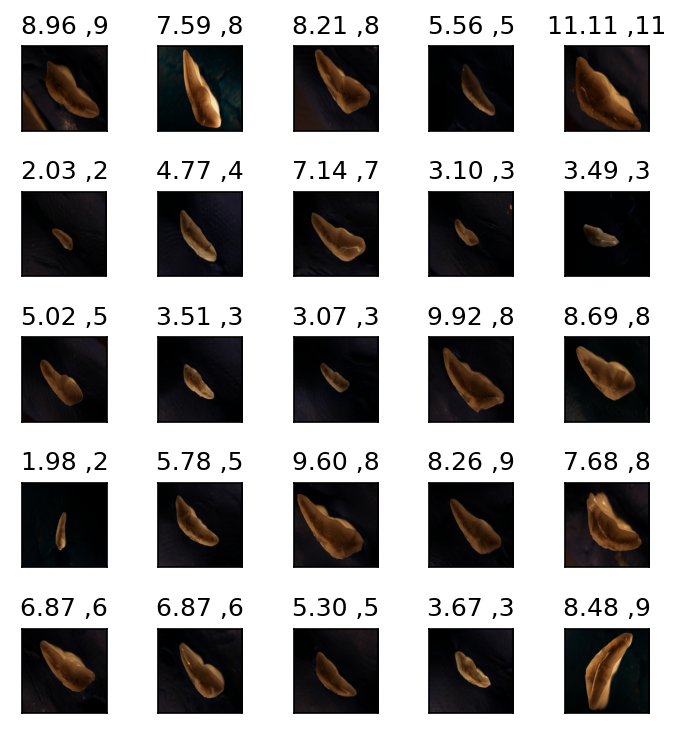

max:11.656976699829102
mean:5.509386144332515
min:1.0240179300308228
test mse:0.43593598646472737
test acc:0.5864077669902913
PREDS TYPE:<class 'list'>


100%|██████████| 58/58 [00:06<00:00,  8.95it/s, Epoch=1, LR=1e-5, Valid_Loss=0.786]


max:12.013795
mean:5.1777987
min:0.6888662
acc:0.5517241379310345
mse:0.85560346
Validation AUC Improved (0 ---> 0.5517241379310345)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=2, LR=9.78e-6, Valid_Loss=0.975]


max:10.810651
mean:4.884369
min:0.469435
acc:0.5
mse:1.0689656



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=3, LR=9.14e-6, Valid_Loss=0.712]


max:11.069767
mean:5.3601823
min:0.53763485
acc:0.6012931034482759
mse:0.7715517
Validation AUC Improved (0.5517241379310345 ---> 0.6012931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  8.97it/s, Epoch=4, LR=8.15e-6, Valid_Loss=0.916]


max:10.65667
mean:5.0144553
min:0.72243756
acc:0.5474137931034483
mse:0.9978448



100%|██████████| 58/58 [00:06<00:00,  9.40it/s, Epoch=5, LR=6.89e-6, Valid_Loss=0.744]


max:10.7355385
mean:5.2373395
min:0.96137714
acc:0.6314655172413793
mse:0.79310346
Validation AUC Improved (0.6012931034482759 ---> 0.6314655172413793)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=6, LR=5.5e-6, Valid_Loss=0.706]


max:11.284915
mean:5.2217145
min:0.7795097
acc:0.6400862068965517
mse:0.7823276
Validation AUC Improved (0.6314655172413793 ---> 0.6400862068965517)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=7, LR=4.11e-6, Valid_Loss=0.708]


max:10.892315
mean:5.186475
min:0.7677361
acc:0.6422413793103449
mse:0.76508623
Validation AUC Improved (0.6400862068965517 ---> 0.6422413793103449)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=8, LR=2.85e-6, Valid_Loss=0.613]


max:11.379459
mean:5.295961
min:0.7251389
acc:0.6530172413793104
mse:0.68318963
Validation AUC Improved (0.6422413793103449 ---> 0.6530172413793104)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=9, LR=1.86e-6, Valid_Loss=0.709]


max:10.996923
mean:5.1600304
min:0.76231277
acc:0.6314655172413793
mse:0.7866379



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=10, LR=1.22e-6, Valid_Loss=0.697]


max:11.308256
mean:5.204611
min:0.8204247
acc:0.6357758620689655
mse:0.7586207



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=11, LR=1e-6, Valid_Loss=0.712]


max:10.883777
mean:5.1304564
min:0.73113364
acc:0.625
mse:0.79956895



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=12, LR=1.22e-6, Valid_Loss=0.69] 


max:10.839614
mean:5.218906
min:0.7407812
acc:0.625
mse:0.76724136



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=13, LR=1.86e-6, Valid_Loss=0.701]


max:10.934131
mean:5.2009244
min:0.75502074
acc:0.6443965517241379
mse:0.76077586



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=14, LR=2.85e-6, Valid_Loss=0.747]


max:11.076463
mean:5.1961274
min:0.7514984
acc:0.6314655172413793
mse:0.81681037



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=15, LR=4.11e-6, Valid_Loss=0.657]


max:11.42959
mean:5.3284135
min:0.8011193
acc:0.6379310344827587
mse:0.73275864



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=16, LR=5.5e-6, Valid_Loss=0.667]


max:11.3313875
mean:5.230955
min:0.72455466
acc:0.6379310344827587
mse:0.73060346



100%|██████████| 58/58 [00:06<00:00,  8.88it/s, Epoch=17, LR=6.89e-6, Valid_Loss=0.624]


max:11.616126
mean:5.3090262
min:0.69305027
acc:0.646551724137931
mse:0.68318963



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=18, LR=8.15e-6, Valid_Loss=0.676]


max:11.091627
mean:5.257845
min:0.75439364
acc:0.6163793103448276
mse:0.7435345



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=19, LR=9.14e-6, Valid_Loss=0.63] 


max:11.182419
mean:5.244294
min:0.8210713
acc:0.6271551724137931
mse:0.70689654



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=20, LR=9.78e-6, Valid_Loss=0.564]


max:11.585104
mean:5.3539186
min:0.8069141
acc:0.6443965517241379
mse:0.6551724



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=21, LR=1e-5, Valid_Loss=0.567]


max:11.660707
mean:5.398606
min:0.9007112
acc:0.6637931034482759
mse:0.625
Validation AUC Improved (0.6530172413793104 ---> 0.6637931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=22, LR=9.78e-6, Valid_Loss=0.591]


max:11.484005
mean:5.1987734
min:0.77406466
acc:0.6530172413793104
mse:0.6465517



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=23, LR=9.14e-6, Valid_Loss=0.592]


max:11.337225
mean:5.356774
min:0.85675514
acc:0.6573275862068966
mse:0.6508621



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=24, LR=8.15e-6, Valid_Loss=0.545]


max:11.542831
mean:5.3435774
min:0.82345647
acc:0.6724137931034483
mse:0.57758623
Validation AUC Improved (0.6637931034482759 ---> 0.6724137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.33it/s, Epoch=25, LR=6.89e-6, Valid_Loss=0.565]


max:11.326441
mean:5.2359853
min:0.80152255
acc:0.6637931034482759
mse:0.62931037



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=26, LR=5.5e-6, Valid_Loss=0.551]


max:11.494992
mean:5.259137
min:0.7982357
acc:0.6637931034482759
mse:0.625



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=27, LR=4.11e-6, Valid_Loss=0.525]


max:11.415043
mean:5.4719505
min:0.8171762
acc:0.6637931034482759
mse:0.57974136



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=28, LR=2.85e-6, Valid_Loss=0.528]


max:11.416677
mean:5.3212934
min:0.79144067
acc:0.6724137931034483
mse:0.5905172
Validation AUC Improved (0.6724137931034483 ---> 0.6724137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=29, LR=1.86e-6, Valid_Loss=0.587]


max:11.401057
mean:5.2338834
min:0.87013096
acc:0.6573275862068966
mse:0.64439654



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=30, LR=1.22e-6, Valid_Loss=0.579]


max:11.302006
mean:5.235061
min:0.801704
acc:0.665948275862069
mse:0.62931037



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=31, LR=1e-6, Valid_Loss=0.529]


max:11.45126
mean:5.348321
min:0.84957415
acc:0.6767241379310345
mse:0.5862069
Validation AUC Improved (0.6724137931034483 ---> 0.6767241379310345)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=32, LR=1.22e-6, Valid_Loss=0.551]


max:11.460812
mean:5.341982
min:0.8390451
acc:0.6724137931034483
mse:0.60991377



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=33, LR=1.86e-6, Valid_Loss=0.545]


max:11.390824
mean:5.304534
min:0.8492566
acc:0.6831896551724138
mse:0.60560346
Validation AUC Improved (0.6767241379310345 ---> 0.6831896551724138)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=34, LR=2.85e-6, Valid_Loss=0.521]


max:11.438146
mean:5.336313
min:0.83832633
acc:0.6745689655172413
mse:0.5948276



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=35, LR=4.11e-6, Valid_Loss=0.564]


max:11.338914
mean:5.2480936
min:0.90311104
acc:0.6616379310344828
mse:0.62068963



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=36, LR=5.5e-6, Valid_Loss=0.526]


max:11.319748
mean:5.3205986
min:0.85211617
acc:0.7047413793103449
mse:0.55818963
Validation AUC Improved (0.6831896551724138 ---> 0.7047413793103449)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=37, LR=6.89e-6, Valid_Loss=0.544]


max:11.6227
mean:5.2690344
min:0.87485164
acc:0.6681034482758621
mse:0.60775864



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=38, LR=8.15e-6, Valid_Loss=0.524]


max:11.717295
mean:5.4005055
min:0.81619453
acc:0.6918103448275862
mse:0.54525864



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=39, LR=9.14e-6, Valid_Loss=0.621]


max:11.496642
mean:5.0916414
min:0.794938
acc:0.6293103448275862
mse:0.6961207



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=40, LR=9.78e-6, Valid_Loss=0.537]


max:11.834506
mean:5.30049
min:0.8267868
acc:0.6745689655172413
mse:0.5948276



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=41, LR=1e-5, Valid_Loss=0.496]


max:11.956584
mean:5.4363546
min:0.88101524
acc:0.6918103448275862
mse:0.54525864



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=42, LR=9.78e-6, Valid_Loss=0.544]


max:11.765145
mean:5.28778
min:0.8481674
acc:0.6831896551724138
mse:0.5862069



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=43, LR=9.14e-6, Valid_Loss=0.52] 


max:11.41726
mean:5.2660027
min:0.8253381
acc:0.6810344827586207
mse:0.57543105



100%|██████████| 58/58 [00:06<00:00,  9.40it/s, Epoch=44, LR=8.15e-6, Valid_Loss=0.495]


max:11.64652
mean:5.353978
min:0.8895041
acc:0.7068965517241379
mse:0.5301724
Validation AUC Improved (0.7047413793103449 ---> 0.7068965517241379)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=45, LR=6.89e-6, Valid_Loss=0.488]


max:11.810989
mean:5.3711395
min:0.9151158
acc:0.7025862068965517
mse:0.51508623



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=46, LR=5.5e-6, Valid_Loss=0.508]


max:11.815642
mean:5.3462186
min:0.85493565
acc:0.6896551724137931
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=47, LR=4.11e-6, Valid_Loss=0.496]


max:11.707231
mean:5.405671
min:0.87103707
acc:0.7047413793103449
mse:0.51939654



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=48, LR=2.85e-6, Valid_Loss=0.496]


max:11.942868
mean:5.37193
min:0.87815064
acc:0.6961206896551724
mse:0.5538793



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=49, LR=1.86e-6, Valid_Loss=0.506]


max:11.717693
mean:5.353123
min:0.8855656
acc:0.7025862068965517
mse:0.54741377



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=50, LR=1.22e-6, Valid_Loss=0.531]


max:11.882148
mean:5.3399076
min:0.86711496
acc:0.7025862068965517
mse:0.5603448



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=51, LR=1e-6, Valid_Loss=0.497]


max:11.872101
mean:5.3285594
min:0.88077414
acc:0.7004310344827587
mse:0.5366379



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=52, LR=1.22e-6, Valid_Loss=0.528]


max:11.6802025
mean:5.284455
min:0.85934705
acc:0.6831896551724138
mse:0.57327586



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=53, LR=1.86e-6, Valid_Loss=0.506]


max:11.645229
mean:5.2906504
min:0.8462056
acc:0.6918103448275862
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.41it/s, Epoch=54, LR=2.85e-6, Valid_Loss=0.511]


max:11.572703
mean:5.328668
min:0.8635141
acc:0.6982758620689655
mse:0.55172414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=55, LR=4.11e-6, Valid_Loss=0.472]


max:12.0137005
mean:5.341544
min:0.8827024
acc:0.7133620689655172
mse:0.51077586
Validation AUC Improved (0.7068965517241379 ---> 0.7133620689655172)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=56, LR=5.5e-6, Valid_Loss=0.487]


max:11.837333
mean:5.3326674
min:0.85758084
acc:0.7047413793103449
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=57, LR=6.89e-6, Valid_Loss=0.489]


max:11.744742
mean:5.331798
min:0.88070977
acc:0.709051724137931
mse:0.5280172



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=58, LR=8.15e-6, Valid_Loss=0.508]


max:11.732226
mean:5.3069215
min:0.90667
acc:0.7025862068965517
mse:0.5409483



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=59, LR=9.14e-6, Valid_Loss=0.493]


max:11.8458605
mean:5.3691854
min:0.89491963
acc:0.6982758620689655
mse:0.5258621



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=60, LR=9.78e-6, Valid_Loss=0.502]


max:11.462587
mean:5.343532
min:0.9534029
acc:0.6831896551724138
mse:0.5538793



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=61, LR=1e-5, Valid_Loss=0.46] 


max:12.184609
mean:5.390487
min:0.90099967
acc:0.7068965517241379
mse:0.49784482



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=62, LR=9.78e-6, Valid_Loss=0.488]


max:11.835414
mean:5.41375
min:0.8594327
acc:0.6939655172413793
mse:0.5237069



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=63, LR=9.14e-6, Valid_Loss=0.5]  


max:11.812884
mean:5.425537
min:0.85653657
acc:0.6853448275862069
mse:0.54525864



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=64, LR=8.15e-6, Valid_Loss=0.532]


max:11.806051
mean:5.2196026
min:0.8348422
acc:0.6702586206896551
mse:0.5862069



100%|██████████| 58/58 [00:06<00:00,  9.33it/s, Epoch=65, LR=6.89e-6, Valid_Loss=0.496]


max:11.906176
mean:5.3263807
min:0.836255
acc:0.7004310344827587
mse:0.54310346



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=66, LR=5.5e-6, Valid_Loss=0.508]


max:11.702879
mean:5.2793345
min:0.8566491
acc:0.6896551724137931
mse:0.5538793



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=67, LR=4.11e-6, Valid_Loss=0.491]


max:11.748331
mean:5.319777
min:0.86691874
acc:0.7047413793103449
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=68, LR=2.85e-6, Valid_Loss=0.496]


max:11.757736
mean:5.3434124
min:0.8614383
acc:0.7025862068965517
mse:0.5344828



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=69, LR=1.86e-6, Valid_Loss=0.475]


max:11.890197
mean:5.352139
min:0.8647922
acc:0.7025862068965517
mse:0.5344828



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=70, LR=1.22e-6, Valid_Loss=0.507]


max:11.920429
mean:5.3313856
min:0.88500524
acc:0.7112068965517241
mse:0.55172414



100%|██████████| 58/58 [00:06<00:00,  9.40it/s, Epoch=71, LR=1e-6, Valid_Loss=0.491]


max:11.885794
mean:5.3197923
min:0.82577324
acc:0.7025862068965517
mse:0.5344828



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=72, LR=1.22e-6, Valid_Loss=0.488]


max:11.849611
mean:5.332904
min:0.8769449
acc:0.6982758620689655
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=73, LR=1.86e-6, Valid_Loss=0.482]


max:11.849009
mean:5.348407
min:0.8897052
acc:0.6982758620689655
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=74, LR=2.85e-6, Valid_Loss=0.484]


max:11.830485
mean:5.3201137
min:0.8792249
acc:0.7004310344827587
mse:0.5366379



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=75, LR=4.11e-6, Valid_Loss=0.484]


max:11.825235
mean:5.3598514
min:0.8682215
acc:0.7068965517241379
mse:0.5237069



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=76, LR=5.5e-6, Valid_Loss=0.497]


max:11.707462
mean:5.314428
min:0.83064985
acc:0.7004310344827587
mse:0.54310346



100%|██████████| 58/58 [00:06<00:00,  9.33it/s, Epoch=77, LR=6.89e-6, Valid_Loss=0.488]


max:11.795681
mean:5.342478
min:0.8373024
acc:0.7004310344827587
mse:0.5301724



100%|██████████| 58/58 [00:06<00:00,  9.41it/s, Epoch=78, LR=8.15e-6, Valid_Loss=0.488]


max:11.644969
mean:5.3024974
min:0.86258274
acc:0.709051724137931
mse:0.5215517



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=79, LR=9.14e-6, Valid_Loss=0.498]


max:11.638476
mean:5.3317423
min:0.8640854
acc:0.6918103448275862
mse:0.55818963



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=80, LR=9.78e-6, Valid_Loss=0.498]


max:11.766949
mean:5.3610635
min:0.91903746
acc:0.7047413793103449
mse:0.5323276



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=81, LR=1e-5, Valid_Loss=0.491]


max:11.819522
mean:5.318355
min:0.8533904
acc:0.7004310344827587
mse:0.54310346

Training complete in 5h 8m 45s
Best AUC: 0.7134


<Figure size 750x750 with 0 Axes>

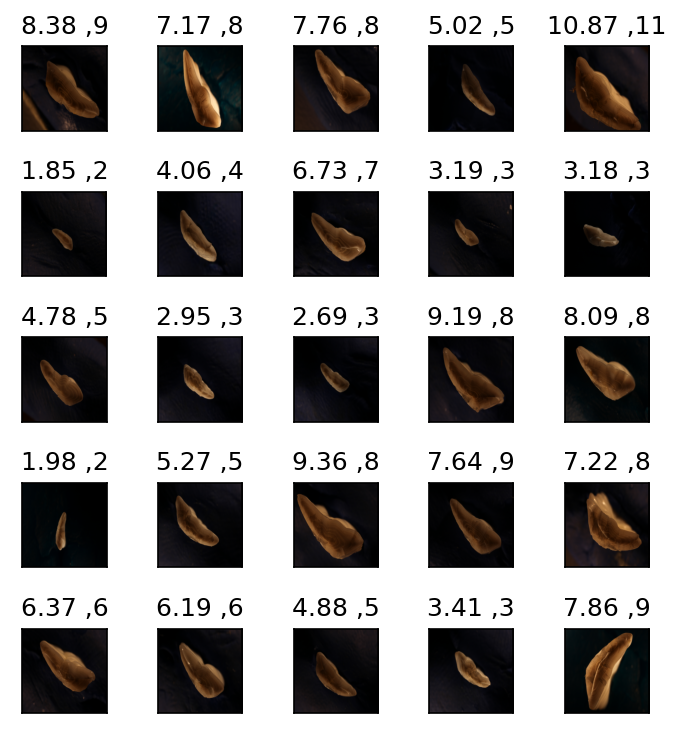

max:11.689010620117188
mean:5.1254937412669355
min:0.9654581546783447
test mse:0.329003091574722
test acc:0.6757281553398058
PREDS TYPE:<class 'list'>


100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=1, LR=1e-5, Valid_Loss=1.31]


max:10.48021
mean:4.8633046
min:0.9425194
acc:0.4396551724137931
mse:1.3469827
Validation AUC Improved (0 ---> 0.4396551724137931)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=2, LR=9.78e-6, Valid_Loss=0.663]


max:12.146557
mean:5.2892046
min:0.76617724
acc:0.5797413793103449
mse:0.7413793
Validation AUC Improved (0.4396551724137931 ---> 0.5797413793103449)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=3, LR=9.14e-6, Valid_Loss=0.764]


max:11.69377
mean:5.1517735
min:0.7283827
acc:0.5474137931034483
mse:0.80818963



100%|██████████| 58/58 [00:06<00:00,  9.35it/s, Epoch=4, LR=8.15e-6, Valid_Loss=0.937]


max:11.011022
mean:4.9894967
min:0.66104794
acc:0.5086206896551724
mse:1.0



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=5, LR=6.89e-6, Valid_Loss=0.836]


max:12.021254
mean:5.0309687
min:0.63086176
acc:0.5301724137931034
mse:0.89224136



100%|██████████| 58/58 [00:06<00:00,  9.16it/s, Epoch=6, LR=5.5e-6, Valid_Loss=0.691]


max:12.036885
mean:5.242336
min:0.69207877
acc:0.5732758620689655
mse:0.79525864



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=7, LR=4.11e-6, Valid_Loss=0.694]


max:12.265549
mean:5.1461906
min:0.71464777
acc:0.5646551724137931
mse:0.81681037



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=8, LR=2.85e-6, Valid_Loss=0.66] 


max:12.366068
mean:5.217745
min:0.62285334
acc:0.5754310344827587
mse:0.7887931



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=9, LR=1.86e-6, Valid_Loss=0.732]


max:11.775323
mean:5.067739
min:0.6221177
acc:0.5538793103448276
mse:0.8146552



100%|██████████| 58/58 [00:06<00:00,  9.39it/s, Epoch=10, LR=1.22e-6, Valid_Loss=0.718]


max:12.098742
mean:5.0991917
min:0.60357004
acc:0.5495689655172413
mse:0.8448276



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=11, LR=1e-6, Valid_Loss=0.597]


max:12.22888
mean:5.209129
min:0.56109476
acc:0.5969827586206896
mse:0.7133621
Validation AUC Improved (0.5797413793103449 ---> 0.5969827586206896)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=12, LR=1.22e-6, Valid_Loss=0.709]


max:12.126512
mean:5.1189485
min:0.64235383
acc:0.5517241379310345
mse:0.82327586



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=13, LR=1.86e-6, Valid_Loss=0.661]


max:12.142635
mean:5.174739
min:0.57240844
acc:0.5711206896551724
mse:0.76508623



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=14, LR=2.85e-6, Valid_Loss=0.651]


max:12.091425
mean:5.1618366
min:0.6083709
acc:0.5926724137931034
mse:0.7478448



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=15, LR=4.11e-6, Valid_Loss=0.618]


max:12.1047325
mean:5.258771
min:0.67716366
acc:0.5797413793103449
mse:0.70043105



100%|██████████| 58/58 [00:06<00:00,  9.17it/s, Epoch=16, LR=5.5e-6, Valid_Loss=0.736]


max:11.598946
mean:5.087896
min:0.68513095
acc:0.5625
mse:0.82543105



100%|██████████| 58/58 [00:06<00:00,  9.21it/s, Epoch=17, LR=6.89e-6, Valid_Loss=0.701]


max:11.391664
mean:5.22295
min:0.63435304
acc:0.5668103448275862
mse:0.82327586



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=18, LR=8.15e-6, Valid_Loss=0.692]


max:11.594302
mean:5.0968723
min:0.7158456
acc:0.5732758620689655
mse:0.79741377



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=19, LR=9.14e-6, Valid_Loss=0.696]


max:11.704399
mean:5.0815854
min:0.58445203
acc:0.5517241379310345
mse:0.7887931



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=20, LR=9.78e-6, Valid_Loss=0.58] 


max:11.693429
mean:5.258884
min:0.6584211
acc:0.6099137931034483
mse:0.625
Validation AUC Improved (0.5969827586206896 ---> 0.6099137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=21, LR=1e-5, Valid_Loss=0.934]


max:11.299207
mean:4.8311462
min:0.609329
acc:0.49137931034482757
mse:0.9762931



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=22, LR=9.78e-6, Valid_Loss=0.606]


max:11.701651
mean:5.1965113
min:0.71123844
acc:0.603448275862069
mse:0.6961207



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=23, LR=9.14e-6, Valid_Loss=0.593]


max:11.310155
mean:5.1830707
min:0.62403166
acc:0.6099137931034483
mse:0.67241377
Validation AUC Improved (0.6099137931034483 ---> 0.6099137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=24, LR=8.15e-6, Valid_Loss=0.749]


max:10.912372
mean:4.9792023
min:0.69208753
acc:0.5366379310344828
mse:0.82758623



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=25, LR=6.89e-6, Valid_Loss=0.533]


max:11.929334
mean:5.2563567
min:0.64468217
acc:0.6271551724137931
mse:0.6271552
Validation AUC Improved (0.6099137931034483 ---> 0.6271551724137931)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=26, LR=5.5e-6, Valid_Loss=0.575]


max:11.333884
mean:5.2043376
min:0.6536702
acc:0.6400862068965517
mse:0.63793105
Validation AUC Improved (0.6271551724137931 ---> 0.6400862068965517)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.38it/s, Epoch=27, LR=4.11e-6, Valid_Loss=0.559]


max:11.490328
mean:5.237868
min:0.6911475
acc:0.6314655172413793
mse:0.6508621



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=28, LR=2.85e-6, Valid_Loss=0.54] 


max:11.420349
mean:5.240878
min:0.6985269
acc:0.6443965517241379
mse:0.6336207
Validation AUC Improved (0.6400862068965517 ---> 0.6443965517241379)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=29, LR=1.86e-6, Valid_Loss=0.529]


max:11.323997
mean:5.206829
min:0.64042455
acc:0.6293103448275862
mse:0.6228448



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=30, LR=1.22e-6, Valid_Loss=0.56] 


max:11.412707
mean:5.2228465
min:0.6932651
acc:0.6271551724137931
mse:0.64439654



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=31, LR=1e-6, Valid_Loss=0.507]


max:11.497055
mean:5.3047547
min:0.7231042
acc:0.6422413793103449
mse:0.5926724



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=32, LR=1.22e-6, Valid_Loss=0.543]


max:11.401226
mean:5.231175
min:0.66283673
acc:0.6379310344827587
mse:0.6336207



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=33, LR=1.86e-6, Valid_Loss=0.502]


max:11.659037
mean:5.302062
min:0.68424004
acc:0.6487068965517241
mse:0.57974136
Validation AUC Improved (0.6443965517241379 ---> 0.6487068965517241)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=34, LR=2.85e-6, Valid_Loss=0.519]


max:11.629016
mean:5.255766
min:0.65594465
acc:0.6530172413793104
mse:0.5926724
Validation AUC Improved (0.6487068965517241 ---> 0.6530172413793104)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=35, LR=4.11e-6, Valid_Loss=0.51] 


max:11.4854965
mean:5.3017325
min:0.7493023
acc:0.6422413793103449
mse:0.6034483



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=36, LR=5.5e-6, Valid_Loss=0.557]


max:11.298017
mean:5.213555
min:0.65573376
acc:0.6357758620689655
mse:0.62931037



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=37, LR=6.89e-6, Valid_Loss=0.499]


max:11.774702
mean:5.3945756
min:0.737234
acc:0.6551724137931034
mse:0.56681037
Validation AUC Improved (0.6530172413793104 ---> 0.6551724137931034)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=38, LR=8.15e-6, Valid_Loss=0.521]


max:11.700544
mean:5.252467
min:0.6551028
acc:0.6314655172413793
mse:0.6336207



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=39, LR=9.14e-6, Valid_Loss=0.558]


max:11.694279
mean:5.260728
min:0.77945477
acc:0.6400862068965517
mse:0.6185345



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=40, LR=9.78e-6, Valid_Loss=0.485]


max:12.110222
mean:5.3543434
min:0.71098614
acc:0.6443965517241379
mse:0.5711207



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=41, LR=1e-5, Valid_Loss=0.607]


max:11.6903105
mean:5.1588955
min:0.7689003
acc:0.6228448275862069
mse:0.67456895



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=42, LR=9.78e-6, Valid_Loss=0.588]


max:12.03288
mean:5.1073766
min:0.81255186
acc:0.6012931034482759
mse:0.6810345



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=43, LR=9.14e-6, Valid_Loss=0.539]


max:11.6179085
mean:5.178811
min:0.6791573
acc:0.625
mse:0.62068963



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=44, LR=8.15e-6, Valid_Loss=0.501]


max:11.648385
mean:5.2880416
min:0.73106456
acc:0.6443965517241379
mse:0.6012931



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=45, LR=6.89e-6, Valid_Loss=0.488]


max:12.112491
mean:5.317934
min:0.7451513
acc:0.6788793103448276
mse:0.54956895
Validation AUC Improved (0.6551724137931034 ---> 0.6788793103448276)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=46, LR=5.5e-6, Valid_Loss=0.482]


max:11.85397
mean:5.3169956
min:0.7694413
acc:0.6681034482758621
mse:0.5603448



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=47, LR=4.11e-6, Valid_Loss=0.465]


max:11.724526
mean:5.3201094
min:0.72958314
acc:0.6788793103448276
mse:0.5301724
Validation AUC Improved (0.6788793103448276 ---> 0.6788793103448276)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=48, LR=2.85e-6, Valid_Loss=0.475]


max:11.817946
mean:5.3109407
min:0.7789284
acc:0.6594827586206896
mse:0.57327586



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=49, LR=1.86e-6, Valid_Loss=0.49] 


max:11.787992
mean:5.289213
min:0.7596572
acc:0.6594827586206896
mse:0.5862069



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=50, LR=1.22e-6, Valid_Loss=0.48] 


max:11.888538
mean:5.2961845
min:0.78260446
acc:0.6702586206896551
mse:0.5625



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=51, LR=1e-6, Valid_Loss=0.484]


max:11.774422
mean:5.2567277
min:0.7440823
acc:0.6594827586206896
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=52, LR=1.22e-6, Valid_Loss=0.481]


max:11.639249
mean:5.2585335
min:0.67530495
acc:0.6637931034482759
mse:0.5689655



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=53, LR=1.86e-6, Valid_Loss=0.498]


max:11.623125
mean:5.254202
min:0.7337627
acc:0.6551724137931034
mse:0.5840517



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=54, LR=2.85e-6, Valid_Loss=0.47] 


max:11.8351
mean:5.322963
min:0.8026997
acc:0.6702586206896551
mse:0.54525864



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=55, LR=4.11e-6, Valid_Loss=0.495]


max:11.849447
mean:5.241713
min:0.71345013
acc:0.6681034482758621
mse:0.57758623



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=56, LR=5.5e-6, Valid_Loss=0.481]


max:11.737171
mean:5.270531
min:0.7043032
acc:0.665948275862069
mse:0.5538793



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=57, LR=6.89e-6, Valid_Loss=0.456]


max:12.004186
mean:5.3231254
min:0.7785987
acc:0.6681034482758621
mse:0.54741377



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=58, LR=8.15e-6, Valid_Loss=0.449]


max:12.170544
mean:5.3844695
min:0.8039293
acc:0.6702586206896551
mse:0.51939654



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=59, LR=9.14e-6, Valid_Loss=0.491]


max:11.830563
mean:5.259696
min:0.79423964
acc:0.6745689655172413
mse:0.5711207



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=60, LR=9.78e-6, Valid_Loss=0.514]


max:11.880755
mean:5.1738772
min:0.7346254
acc:0.6443965517241379
mse:0.60560346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=61, LR=1e-5, Valid_Loss=0.488]


max:11.881746
mean:5.2869267
min:0.7924897
acc:0.665948275862069
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=62, LR=9.78e-6, Valid_Loss=0.465]


max:11.775403
mean:5.307815
min:0.8322437
acc:0.6831896551724138
mse:0.5560345
Validation AUC Improved (0.6788793103448276 ---> 0.6831896551724138)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=63, LR=9.14e-6, Valid_Loss=0.454]


max:11.96324
mean:5.2906475
min:0.84657556
acc:0.6637931034482759
mse:0.54525864



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=64, LR=8.15e-6, Valid_Loss=0.444]


max:11.999825
mean:5.363398
min:0.7994488
acc:0.6788793103448276
mse:0.5215517



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=65, LR=6.89e-6, Valid_Loss=0.447]


max:12.199645
mean:5.356003
min:0.82704425
acc:0.6810344827586207
mse:0.5215517



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=66, LR=5.5e-6, Valid_Loss=0.481]


max:12.064244
mean:5.209065
min:0.7839579
acc:0.665948275862069
mse:0.56681037



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=67, LR=4.11e-6, Valid_Loss=0.452]


max:11.903302
mean:5.272002
min:0.78552425
acc:0.6724137931034483
mse:0.5323276



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=68, LR=2.85e-6, Valid_Loss=0.437]


max:11.828619
mean:5.3008714
min:0.7923997
acc:0.665948275862069
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=69, LR=1.86e-6, Valid_Loss=0.452]


max:11.980729
mean:5.3030815
min:0.8360953
acc:0.6788793103448276
mse:0.5409483



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=70, LR=1.22e-6, Valid_Loss=0.441]


max:11.990323
mean:5.3049884
min:0.7888624
acc:0.6788793103448276
mse:0.5086207



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=71, LR=1e-6, Valid_Loss=0.437]


max:12.084239
mean:5.3117986
min:0.85210204
acc:0.6918103448275862
mse:0.5
Validation AUC Improved (0.6831896551724138 ---> 0.6918103448275862)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=72, LR=1.22e-6, Valid_Loss=0.426]


max:11.997918
mean:5.3006635
min:0.7753685
acc:0.665948275862069
mse:0.51077586



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=73, LR=1.86e-6, Valid_Loss=0.428]


max:11.996467
mean:5.329174
min:0.7836377
acc:0.6767241379310345
mse:0.50431037



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=74, LR=2.85e-6, Valid_Loss=0.448]


max:11.80824
mean:5.246466
min:0.67968416
acc:0.6594827586206896
mse:0.5344828



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=75, LR=4.11e-6, Valid_Loss=0.452]


max:12.033364
mean:5.2910137
min:0.84901416
acc:0.6810344827586207
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=76, LR=5.5e-6, Valid_Loss=0.438]


max:12.158126
mean:5.305406
min:0.8440904
acc:0.6767241379310345
mse:0.5215517



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=77, LR=6.89e-6, Valid_Loss=0.431]


max:11.821217
mean:5.3028297
min:0.7781496
acc:0.6788793103448276
mse:0.51508623



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=78, LR=8.15e-6, Valid_Loss=0.47] 


max:11.876683
mean:5.245492
min:0.80170214
acc:0.6637931034482759
mse:0.5560345



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=79, LR=9.14e-6, Valid_Loss=0.447]


max:12.110277
mean:5.3149047
min:0.8137367
acc:0.6961206896551724
mse:0.50431037
Validation AUC Improved (0.6918103448275862 ---> 0.6961206896551724)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=80, LR=9.78e-6, Valid_Loss=0.478]


max:11.667136
mean:5.261934
min:0.8520546
acc:0.6681034482758621
mse:0.54310346



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=81, LR=1e-5, Valid_Loss=0.452]


max:12.107564
mean:5.251548
min:0.84979147
acc:0.6875
mse:0.51724136



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=82, LR=9.78e-6, Valid_Loss=0.468]


max:11.942164
mean:5.285045
min:0.85496604
acc:0.6788793103448276
mse:0.54310346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=83, LR=9.14e-6, Valid_Loss=0.454]


max:12.024988
mean:5.2234793
min:0.73150325
acc:0.6702586206896551
mse:0.5301724



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=84, LR=8.15e-6, Valid_Loss=0.412]


max:12.141297
mean:5.3513427
min:0.7951033
acc:0.6831896551724138
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=85, LR=6.89e-6, Valid_Loss=0.455]


max:11.845476
mean:5.2883677
min:0.82353723
acc:0.6810344827586207
mse:0.5301724



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=86, LR=5.5e-6, Valid_Loss=0.457]


max:11.878236
mean:5.22052
min:0.8168874
acc:0.6724137931034483
mse:0.5387931



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=87, LR=4.11e-6, Valid_Loss=0.454]


max:11.994386
mean:5.2615094
min:0.819197
acc:0.6745689655172413
mse:0.5301724



100%|██████████| 58/58 [00:06<00:00,  9.13it/s, Epoch=88, LR=2.85e-6, Valid_Loss=0.427]


max:11.965052
mean:5.3048506
min:0.8645492
acc:0.6875
mse:0.4698276



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=89, LR=1.86e-6, Valid_Loss=0.428]


max:12.189049
mean:5.3330574
min:0.86108077
acc:0.6918103448275862
mse:0.46336207



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=90, LR=1.22e-6, Valid_Loss=0.432]


max:11.992182
mean:5.288876
min:0.84039694
acc:0.6896551724137931
mse:0.48922414



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=91, LR=1e-6, Valid_Loss=0.443]


max:11.95233
mean:5.302465
min:0.820428
acc:0.6853448275862069
mse:0.48922414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=92, LR=1.22e-6, Valid_Loss=0.444]


max:12.128278
mean:5.310711
min:0.8559381
acc:0.6982758620689655
mse:0.49137932
Validation AUC Improved (0.6961206896551724 ---> 0.6982758620689655)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=93, LR=1.86e-6, Valid_Loss=0.421]


max:12.10783
mean:5.3229012
min:0.8476403
acc:0.6853448275862069
mse:0.47844827



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=94, LR=2.85e-6, Valid_Loss=0.433]


max:12.105831
mean:5.2946305
min:0.82046056
acc:0.6810344827586207
mse:0.48706895



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=95, LR=4.11e-6, Valid_Loss=0.428]


max:12.181684
mean:5.34133
min:0.87998044
acc:0.7004310344827587
mse:0.4676724
Validation AUC Improved (0.6982758620689655 ---> 0.7004310344827587)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=96, LR=5.5e-6, Valid_Loss=0.407]


max:12.191959
mean:5.3644977
min:0.82922614
acc:0.6939655172413793
mse:0.45043105



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=97, LR=6.89e-6, Valid_Loss=0.43] 


max:12.058188
mean:5.324428
min:0.8608092
acc:0.6939655172413793
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=98, LR=8.15e-6, Valid_Loss=0.452]


max:12.242704
mean:5.2687216
min:0.8494359
acc:0.6831896551724138
mse:0.51077586



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=99, LR=9.14e-6, Valid_Loss=0.426]


max:12.061019
mean:5.317891
min:0.9007082
acc:0.6853448275862069
mse:0.47844827



100%|██████████| 58/58 [00:06<00:00,  9.19it/s, Epoch=100, LR=9.78e-6, Valid_Loss=0.426]


max:12.5560055
mean:5.3705034
min:0.86971813
acc:0.6853448275862069
mse:0.50431037



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=101, LR=1e-5, Valid_Loss=0.408]


max:12.34367
mean:5.4349027
min:0.8161858
acc:0.6896551724137931
mse:0.45043105



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=102, LR=9.78e-6, Valid_Loss=0.421]


max:12.417259
mean:5.358598
min:0.8794196
acc:0.6875
mse:0.4698276



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=103, LR=9.14e-6, Valid_Loss=0.435]


max:12.158652
mean:5.359356
min:0.8751828
acc:0.7025862068965517
mse:0.45905173
Validation AUC Improved (0.7004310344827587 ---> 0.7025862068965517)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=104, LR=8.15e-6, Valid_Loss=0.438]


max:12.185065
mean:5.29151
min:0.82765543
acc:0.6875
mse:0.5



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=105, LR=6.89e-6, Valid_Loss=0.411]


max:12.290169
mean:5.371677
min:0.8570356
acc:0.6875
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=106, LR=5.5e-6, Valid_Loss=0.414]


max:12.192789
mean:5.3364635
min:0.871567
acc:0.6918103448275862
mse:0.46551725



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=107, LR=4.11e-6, Valid_Loss=0.413]


max:12.265387
mean:5.304147
min:0.8735917
acc:0.6982758620689655
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=108, LR=2.85e-6, Valid_Loss=0.411]


max:12.282913
mean:5.2967997
min:0.8746341
acc:0.6875
mse:0.47198275



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=109, LR=1.86e-6, Valid_Loss=0.416]


max:12.226316
mean:5.3398323
min:0.8797982
acc:0.6918103448275862
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=110, LR=1.22e-6, Valid_Loss=0.44] 


max:12.127097
mean:5.240192
min:0.80435365
acc:0.6745689655172413
mse:0.51508623



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=111, LR=1e-6, Valid_Loss=0.405]


max:12.187315
mean:5.350961
min:0.9016691
acc:0.6939655172413793
mse:0.43965518



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=112, LR=1.22e-6, Valid_Loss=0.424]


max:12.059988
mean:5.3160844
min:0.869433
acc:0.6896551724137931
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=113, LR=1.86e-6, Valid_Loss=0.429]


max:12.190505
mean:5.3312035
min:0.8646228
acc:0.6853448275862069
mse:0.4827586



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=114, LR=2.85e-6, Valid_Loss=0.429]


max:12.218287
mean:5.355554
min:0.87035424
acc:0.6896551724137931
mse:0.47198275



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=115, LR=4.11e-6, Valid_Loss=0.406]


max:12.217317
mean:5.3305087
min:0.86429757
acc:0.6918103448275862
mse:0.44827586



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=116, LR=5.5e-6, Valid_Loss=0.405]


max:12.509586
mean:5.3796134
min:0.8761577
acc:0.7068965517241379
mse:0.4375
Validation AUC Improved (0.7025862068965517 ---> 0.7068965517241379)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=117, LR=6.89e-6, Valid_Loss=0.424]


max:12.16639
mean:5.3068542
min:0.8697295
acc:0.6982758620689655
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=118, LR=8.15e-6, Valid_Loss=0.427]


max:12.134223
mean:5.267553
min:0.8712295
acc:0.6724137931034483
mse:0.48706895



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=119, LR=9.14e-6, Valid_Loss=0.418]


max:12.143861
mean:5.29501
min:0.868824
acc:0.7047413793103449
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.21it/s, Epoch=120, LR=9.78e-6, Valid_Loss=0.426]


max:12.171284
mean:5.325172
min:0.8276635
acc:0.6939655172413793
mse:0.46336207



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=121, LR=1e-5, Valid_Loss=0.399]


max:12.366134
mean:5.3701615
min:0.86972845
acc:0.6961206896551724
mse:0.4375



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=122, LR=9.78e-6, Valid_Loss=0.417]


max:12.097672
mean:5.3164153
min:0.8853664
acc:0.6918103448275862
mse:0.47413793



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=123, LR=9.14e-6, Valid_Loss=0.425]


max:12.216515
mean:5.271335
min:0.83342373
acc:0.6853448275862069
mse:0.47844827



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=124, LR=8.15e-6, Valid_Loss=0.409]


max:12.283847
mean:5.319882
min:0.86854887
acc:0.7068965517241379
mse:0.4375
Validation AUC Improved (0.7068965517241379 ---> 0.7068965517241379)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=125, LR=6.89e-6, Valid_Loss=0.398]


max:12.170213
mean:5.337759
min:0.86092514
acc:0.7025862068965517
mse:0.4375



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=126, LR=5.5e-6, Valid_Loss=0.415]


max:12.020264
mean:5.3250036
min:0.8742633
acc:0.6853448275862069
mse:0.4849138



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=127, LR=4.11e-6, Valid_Loss=0.422]


max:12.106835
mean:5.3369446
min:0.86179674
acc:0.6875
mse:0.46336207



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=128, LR=2.85e-6, Valid_Loss=0.416]


max:12.139214
mean:5.3132367
min:0.88848466
acc:0.6939655172413793
mse:0.45043105



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=129, LR=1.86e-6, Valid_Loss=0.411]


max:12.210917
mean:5.346241
min:0.87657106
acc:0.6961206896551724
mse:0.44827586



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=130, LR=1.22e-6, Valid_Loss=0.402]


max:12.190499
mean:5.3379536
min:0.8846817
acc:0.6939655172413793
mse:0.4525862



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=131, LR=1e-6, Valid_Loss=0.421]


max:12.259089
mean:5.307068
min:0.86234194
acc:0.7047413793103449
mse:0.44612068



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=132, LR=1.22e-6, Valid_Loss=0.421]


max:12.096682
mean:5.286194
min:0.8518329
acc:0.6875
mse:0.48706895



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=133, LR=1.86e-6, Valid_Loss=0.409]


max:12.168763
mean:5.334014
min:0.8865761
acc:0.6896551724137931
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=134, LR=2.85e-6, Valid_Loss=0.417]


max:12.227511
mean:5.295959
min:0.91067433
acc:0.6918103448275862
mse:0.47198275



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=135, LR=4.11e-6, Valid_Loss=0.407]


max:12.280077
mean:5.334423
min:0.87528855
acc:0.6982758620689655
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=136, LR=5.5e-6, Valid_Loss=0.408]


max:12.344588
mean:5.31226
min:0.899543
acc:0.6853448275862069
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=137, LR=6.89e-6, Valid_Loss=0.395]


max:12.437389
mean:5.4158144
min:0.91154885
acc:0.7025862068965517
mse:0.4375



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=138, LR=8.15e-6, Valid_Loss=0.411]


max:12.189725
mean:5.3373313
min:0.905347
acc:0.6810344827586207
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=139, LR=9.14e-6, Valid_Loss=0.434]


max:12.274687
mean:5.2767916
min:0.8707081
acc:0.6810344827586207
mse:0.48706895



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=140, LR=9.78e-6, Valid_Loss=0.411]


max:12.372003
mean:5.3248754
min:0.8988107
acc:0.6810344827586207
mse:0.47629312



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=141, LR=1e-5, Valid_Loss=0.414]


max:12.20017
mean:5.2928214
min:0.8789277
acc:0.6810344827586207
mse:0.47844827



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=142, LR=9.78e-6, Valid_Loss=0.422]


max:12.140975
mean:5.303232
min:0.91653436
acc:0.6767241379310345
mse:0.4827586



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=143, LR=9.14e-6, Valid_Loss=0.409]


max:12.211411
mean:5.29507
min:0.9022471
acc:0.6961206896551724
mse:0.45043105



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=144, LR=8.15e-6, Valid_Loss=0.427]


max:12.166323
mean:5.2819195
min:0.83727384
acc:0.6788793103448276
mse:0.49137932



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=145, LR=6.89e-6, Valid_Loss=0.409]


max:12.2322445
mean:5.300426
min:0.9124342
acc:0.6853448275862069
mse:0.4676724



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=146, LR=5.5e-6, Valid_Loss=0.401]


max:12.271389
mean:5.3609567
min:0.87716806
acc:0.6939655172413793
mse:0.44396552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=147, LR=4.11e-6, Valid_Loss=0.413]


max:12.131453
mean:5.313931
min:0.86824155
acc:0.6939655172413793
mse:0.46336207



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=148, LR=2.85e-6, Valid_Loss=0.412]


max:12.259554
mean:5.2853427
min:0.8509036
acc:0.6896551724137931
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.22it/s, Epoch=149, LR=1.86e-6, Valid_Loss=0.406]


max:12.295751
mean:5.3457794
min:0.8924848
acc:0.6918103448275862
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=150, LR=1.22e-6, Valid_Loss=0.414]


max:12.244126
mean:5.3010645
min:0.87470996
acc:0.6831896551724138
mse:0.4676724

Training complete in 9h 31m 37s
Best AUC: 0.7069


<Figure size 750x750 with 0 Axes>

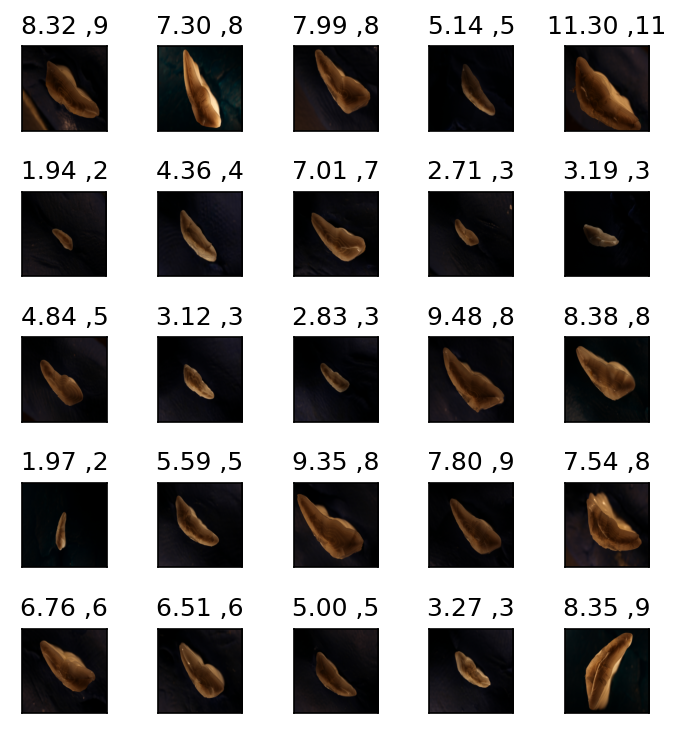

max:11.889851570129395
mean:5.285319744498985
min:0.9146838188171387
test mse:0.33623309593114964
test acc:0.6776699029126214
PREDS TYPE:<class 'list'>


100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=1, LR=1e-5, Valid_Loss=0.832]


max:12.934731
mean:5.471157
min:0.53694016
acc:0.5495689655172413
mse:0.87068963
Validation AUC Improved (0 ---> 0.5495689655172413)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=2, LR=9.78e-6, Valid_Loss=0.732]


max:11.670882
mean:5.0639133
min:0.47898865
acc:0.5603448275862069
mse:0.80172414
Validation AUC Improved (0.5495689655172413 ---> 0.5603448275862069)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=3, LR=9.14e-6, Valid_Loss=0.68] 


max:11.661931
mean:5.258528
min:0.68840855
acc:0.5926724137931034
mse:0.7262931
Validation AUC Improved (0.5603448275862069 ---> 0.5926724137931034)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.11it/s, Epoch=4, LR=8.15e-6, Valid_Loss=0.626]


max:12.212154
mean:5.1496515
min:0.4080102
acc:0.5732758620689655
mse:0.70258623



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=5, LR=6.89e-6, Valid_Loss=0.792]


max:12.364469
mean:5.240235
min:0.5905834
acc:0.5969827586206896
mse:0.82974136
Validation AUC Improved (0.5926724137931034 ---> 0.5969827586206896)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=6, LR=5.5e-6, Valid_Loss=0.807]


max:11.524659
mean:5.21911
min:0.5341228
acc:0.5646551724137931
mse:0.8340517



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=7, LR=4.11e-6, Valid_Loss=0.658]


max:12.481889
mean:5.177978
min:0.42505077
acc:0.5883620689655172
mse:0.74568963



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=8, LR=2.85e-6, Valid_Loss=0.657]


max:12.132513
mean:5.230816
min:0.6570635
acc:0.5969827586206896
mse:0.73706895
Validation AUC Improved (0.5969827586206896 ---> 0.5969827586206896)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=9, LR=1.86e-6, Valid_Loss=0.717]


max:11.833075
mean:5.2408257
min:0.51563686
acc:0.5818965517241379
mse:0.79525864



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=10, LR=1.22e-6, Valid_Loss=0.577]


max:12.378445
mean:5.2291503
min:0.43990713
acc:0.5991379310344828
mse:0.6336207
Validation AUC Improved (0.5969827586206896 ---> 0.5991379310344828)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=11, LR=1e-6, Valid_Loss=0.858]


max:11.929933
mean:5.141394
min:0.4492029
acc:0.6012931034482759
mse:0.95043105
Validation AUC Improved (0.5991379310344828 ---> 0.6012931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=12, LR=1.22e-6, Valid_Loss=0.64] 


max:12.209822
mean:5.1403594
min:0.5335447
acc:0.5991379310344828
mse:0.67672414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=13, LR=1.86e-6, Valid_Loss=0.604]


max:12.225308
mean:5.1805797
min:0.4619563
acc:0.6077586206896551
mse:0.66810346
Validation AUC Improved (0.6012931034482759 ---> 0.6077586206896551)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=14, LR=2.85e-6, Valid_Loss=0.594]


max:12.289744
mean:5.246644
min:0.531332
acc:0.6012931034482759
mse:0.6163793



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=15, LR=4.11e-6, Valid_Loss=0.523]


max:13.019625
mean:5.3786063
min:0.6147566
acc:0.5818965517241379
mse:0.6163793



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=16, LR=5.5e-6, Valid_Loss=0.606]


max:12.742874
mean:5.4493294
min:0.6217565
acc:0.5754310344827587
mse:0.6939655



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=17, LR=6.89e-6, Valid_Loss=0.583]


max:12.068797
mean:5.19868
min:0.51868546
acc:0.5969827586206896
mse:0.6314655



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=18, LR=8.15e-6, Valid_Loss=0.588]


max:11.863012
mean:5.2582946
min:0.63231933
acc:0.5948275862068966
mse:0.6810345



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=19, LR=9.14e-6, Valid_Loss=0.557]


max:11.833163
mean:5.26287
min:0.71098894
acc:0.6099137931034483
mse:0.61422414
Validation AUC Improved (0.6077586206896551 ---> 0.6099137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=20, LR=9.78e-6, Valid_Loss=0.564]


max:12.577932
mean:5.34719
min:0.78714615
acc:0.5926724137931034
mse:0.60560346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=21, LR=1e-5, Valid_Loss=0.746]


max:12.211067
mean:5.012688
min:0.62549984
acc:0.5538793103448276
mse:0.8146552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=22, LR=9.78e-6, Valid_Loss=0.678]


max:11.788719
mean:5.165994
min:0.72817636
acc:0.6142241379310345
mse:0.76508623
Validation AUC Improved (0.6099137931034483 ---> 0.6142241379310345)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=23, LR=9.14e-6, Valid_Loss=0.522]


max:12.255821
mean:5.355914
min:0.74794006
acc:0.6163793103448276
mse:0.57758623
Validation AUC Improved (0.6142241379310345 ---> 0.6163793103448276)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=24, LR=8.15e-6, Valid_Loss=0.546]


max:12.00402
mean:5.2644706
min:0.72039604
acc:0.6206896551724138
mse:0.5883621
Validation AUC Improved (0.6163793103448276 ---> 0.6206896551724138)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=25, LR=6.89e-6, Valid_Loss=0.494]


max:12.235609
mean:5.347687
min:0.68161166
acc:0.6185344827586207
mse:0.57974136



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=26, LR=5.5e-6, Valid_Loss=0.581]


max:11.8592615
mean:5.228364
min:0.7207705
acc:0.6314655172413793
mse:0.625
Validation AUC Improved (0.6206896551724138 ---> 0.6314655172413793)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=27, LR=4.11e-6, Valid_Loss=0.491]


max:12.135142
mean:5.393019
min:0.76311886
acc:0.6551724137931034
mse:0.51293105
Validation AUC Improved (0.6314655172413793 ---> 0.6551724137931034)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=28, LR=2.85e-6, Valid_Loss=0.482]


max:12.21614
mean:5.396174
min:0.7265543
acc:0.6508620689655172
mse:0.51724136



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=29, LR=1.86e-6, Valid_Loss=0.471]


max:12.21538
mean:5.428147
min:0.77157086
acc:0.6594827586206896
mse:0.47629312
Validation AUC Improved (0.6551724137931034 ---> 0.6594827586206896)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=30, LR=1.22e-6, Valid_Loss=0.455]


max:12.172809
mean:5.361327
min:0.7216455
acc:0.6293103448275862
mse:0.51939654



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=31, LR=1e-6, Valid_Loss=0.5]  


max:12.005226
mean:5.317384
min:0.73767555
acc:0.6379310344827587
mse:0.54741377



100%|██████████| 58/58 [00:06<00:00,  9.08it/s, Epoch=32, LR=1.22e-6, Valid_Loss=0.526]


max:11.957472
mean:5.3578176
min:0.73464805
acc:0.6616379310344828
mse:0.5344828
Validation AUC Improved (0.6594827586206896 ---> 0.6616379310344828)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=33, LR=1.86e-6, Valid_Loss=0.534]


max:11.830107
mean:5.3061376
min:0.76938224
acc:0.6422413793103449
mse:0.5862069



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=34, LR=2.85e-6, Valid_Loss=0.513]


max:12.168854
mean:5.3096566
min:0.66860825
acc:0.6314655172413793
mse:0.54956895



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=35, LR=4.11e-6, Valid_Loss=0.482]


max:12.029184
mean:5.316493
min:0.74432266
acc:0.6508620689655172
mse:0.51724136



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=36, LR=5.5e-6, Valid_Loss=0.524]


max:11.822773
mean:5.367178
min:0.7521444
acc:0.6422413793103449
mse:0.57758623



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=37, LR=6.89e-6, Valid_Loss=0.455]


max:11.928537
mean:5.3441114
min:0.77860993
acc:0.6336206896551724
mse:0.5021552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=38, LR=8.15e-6, Valid_Loss=0.512]


max:11.976506
mean:5.483027
min:0.7592529
acc:0.6120689655172413
mse:0.5689655



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=39, LR=9.14e-6, Valid_Loss=0.501]


max:11.975302
mean:5.2641406
min:0.76986396
acc:0.6379310344827587
mse:0.5625



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=40, LR=9.78e-6, Valid_Loss=0.452]


max:12.076874
mean:5.4194913
min:0.7568255
acc:0.6422413793103449
mse:0.49353448



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=41, LR=1e-5, Valid_Loss=0.482]


max:11.608658
mean:5.408619
min:0.7173426
acc:0.6314655172413793
mse:0.5237069



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=42, LR=9.78e-6, Valid_Loss=0.456]


max:12.130661
mean:5.3331804
min:0.7374359
acc:0.6271551724137931
mse:0.5021552



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=43, LR=9.14e-6, Valid_Loss=0.438]


max:11.888178
mean:5.4363594
min:0.81193894
acc:0.6637931034482759
mse:0.47844827
Validation AUC Improved (0.6616379310344828 ---> 0.6637931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=44, LR=8.15e-6, Valid_Loss=0.47] 


max:11.500189
mean:5.3130937
min:0.7402666
acc:0.6314655172413793
mse:0.54956895



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=45, LR=6.89e-6, Valid_Loss=0.448]


max:11.687833
mean:5.3894153
min:0.7690905
acc:0.6551724137931034
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  8.98it/s, Epoch=46, LR=5.5e-6, Valid_Loss=0.457]


max:11.68281
mean:5.4181867
min:0.8439723
acc:0.6487068965517241
mse:0.5



100%|██████████| 58/58 [00:06<00:00,  9.37it/s, Epoch=47, LR=4.11e-6, Valid_Loss=0.439]


max:11.844846
mean:5.431854
min:0.79580307
acc:0.6487068965517241
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=48, LR=2.85e-6, Valid_Loss=0.443]


max:11.801982
mean:5.409395
min:0.8183592
acc:0.6637931034482759
mse:0.47198275
Validation AUC Improved (0.6637931034482759 ---> 0.6637931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.35it/s, Epoch=49, LR=1.86e-6, Valid_Loss=0.45] 


max:11.785966
mean:5.365316
min:0.78121823
acc:0.6530172413793104
mse:0.4827586



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=50, LR=1.22e-6, Valid_Loss=0.425]


max:11.92412
mean:5.422039
min:0.71827245
acc:0.6616379310344828
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=51, LR=1e-6, Valid_Loss=0.437]


max:11.7937765
mean:5.398255
min:0.7548423
acc:0.6551724137931034
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=52, LR=1.22e-6, Valid_Loss=0.448]


max:11.685993
mean:5.379035
min:0.7767575
acc:0.6530172413793104
mse:0.47629312



100%|██████████| 58/58 [00:06<00:00,  9.19it/s, Epoch=53, LR=1.86e-6, Valid_Loss=0.437]


max:11.751437
mean:5.3719616
min:0.7751807
acc:0.646551724137931
mse:0.48922414



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=54, LR=2.85e-6, Valid_Loss=0.467]


max:11.749607
mean:5.428588
min:0.80264175
acc:0.6637931034482759
mse:0.4849138
Validation AUC Improved (0.6637931034482759 ---> 0.6637931034482759)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=55, LR=4.11e-6, Valid_Loss=0.435]


max:11.7941265
mean:5.393381
min:0.80545425
acc:0.6573275862068966
mse:0.4849138



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=56, LR=5.5e-6, Valid_Loss=0.412]


max:12.104109
mean:5.4377437
min:0.72013646
acc:0.6616379310344828
mse:0.4676724



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=57, LR=6.89e-6, Valid_Loss=0.451]


max:12.012156
mean:5.379145
min:0.7693263
acc:0.6400862068965517
mse:0.49568966



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=58, LR=8.15e-6, Valid_Loss=0.44] 


max:11.8391285
mean:5.354989
min:0.7306586
acc:0.6443965517241379
mse:0.49784482



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=59, LR=9.14e-6, Valid_Loss=0.45] 


max:12.100248
mean:5.3286586
min:0.7475664
acc:0.6271551724137931
mse:0.5409483



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=60, LR=9.78e-6, Valid_Loss=0.443]


max:12.488154
mean:5.3492804
min:0.75087434
acc:0.6293103448275862
mse:0.51293105



100%|██████████| 58/58 [00:06<00:00,  9.02it/s, Epoch=61, LR=1e-5, Valid_Loss=0.438]


max:12.098387
mean:5.4292164
min:0.7368742
acc:0.6443965517241379
mse:0.49784482



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=62, LR=9.78e-6, Valid_Loss=0.423]


max:12.16281
mean:5.446743
min:0.75622183
acc:0.6487068965517241
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=63, LR=9.14e-6, Valid_Loss=0.426]


max:12.293666
mean:5.488225
min:0.7817333
acc:0.6400862068965517
mse:0.47629312



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=64, LR=8.15e-6, Valid_Loss=0.402]


max:12.11409
mean:5.4075356
min:0.8290592
acc:0.6594827586206896
mse:0.46120688



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=65, LR=6.89e-6, Valid_Loss=0.403]


max:12.244591
mean:5.470813
min:0.78357506
acc:0.6508620689655172
mse:0.47198275



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=66, LR=5.5e-6, Valid_Loss=0.438]


max:12.059787
mean:5.388636
min:0.807185
acc:0.6551724137931034
mse:0.5



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=67, LR=4.11e-6, Valid_Loss=0.416]


max:12.343754
mean:5.4409757
min:0.85497105
acc:0.6508620689655172
mse:0.46551725



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=68, LR=2.85e-6, Valid_Loss=0.425]


max:11.976781
mean:5.4091663
min:0.76907855
acc:0.646551724137931
mse:0.48922414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=69, LR=1.86e-6, Valid_Loss=0.414]


max:12.005072
mean:5.3866544
min:0.79650927
acc:0.6422413793103449
mse:0.49353448



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=70, LR=1.22e-6, Valid_Loss=0.426]


max:11.98672
mean:5.410133
min:0.8198601
acc:0.6594827586206896
mse:0.47629312



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=71, LR=1e-6, Valid_Loss=0.402]


max:12.191225
mean:5.4052176
min:0.82535124
acc:0.6487068965517241
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=72, LR=1.22e-6, Valid_Loss=0.406]


max:12.011991
mean:5.364726
min:0.7491722
acc:0.665948275862069
mse:0.45689654
Validation AUC Improved (0.6637931034482759 ---> 0.665948275862069)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=73, LR=1.86e-6, Valid_Loss=0.442]


max:11.834255
mean:5.34176
min:0.8021207
acc:0.6422413793103449
mse:0.5258621



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=74, LR=2.85e-6, Valid_Loss=0.411]


max:12.016513
mean:5.4023046
min:0.76701266
acc:0.6443965517241379
mse:0.49137932



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=75, LR=4.11e-6, Valid_Loss=0.435]


max:11.977193
mean:5.3640127
min:0.7809958
acc:0.6336206896551724
mse:0.5021552



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=76, LR=5.5e-6, Valid_Loss=0.418]


max:11.965949
mean:5.4648957
min:0.822034
acc:0.6487068965517241
mse:0.4676724



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=77, LR=6.89e-6, Valid_Loss=0.414]


max:12.333739
mean:5.4082303
min:0.7738333
acc:0.6637931034482759
mse:0.46551725



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=78, LR=8.15e-6, Valid_Loss=0.423]


max:11.876978
mean:5.4390507
min:0.8610788
acc:0.646551724137931
mse:0.47629312



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=79, LR=9.14e-6, Valid_Loss=0.442]


max:11.7392235
mean:5.3129597
min:0.8142888
acc:0.6379310344827587
mse:0.5366379



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=80, LR=9.78e-6, Valid_Loss=0.43] 


max:11.943213
mean:5.3210535
min:0.8224806
acc:0.6379310344827587
mse:0.51724136



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=81, LR=1e-5, Valid_Loss=0.398]


max:11.738019
mean:5.3653255
min:0.8151906
acc:0.6681034482758621
mse:0.4525862
Validation AUC Improved (0.665948275862069 ---> 0.6681034482758621)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  8.99it/s, Epoch=82, LR=9.78e-6, Valid_Loss=0.445]


max:11.925734
mean:5.375682
min:0.7850777
acc:0.6637931034482759
mse:0.5086207



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=83, LR=9.14e-6, Valid_Loss=0.399]


max:12.060894
mean:5.3131156
min:0.80806005
acc:0.6422413793103449
mse:0.47844827



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=84, LR=8.15e-6, Valid_Loss=0.418]


max:11.908926
mean:5.4222465
min:0.8264016
acc:0.6551724137931034
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=85, LR=6.89e-6, Valid_Loss=0.406]


max:11.989117
mean:5.335227
min:0.82308
acc:0.6616379310344828
mse:0.49353448



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=86, LR=5.5e-6, Valid_Loss=0.4]  


max:11.875582
mean:5.4019923
min:0.85257566
acc:0.6616379310344828
mse:0.4525862



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=87, LR=4.11e-6, Valid_Loss=0.402]


max:12.021879
mean:5.3935094
min:0.8209786
acc:0.6637931034482759
mse:0.46551725



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=88, LR=2.85e-6, Valid_Loss=0.401]


max:12.12573
mean:5.4263268
min:0.88454515
acc:0.6573275862068966
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=89, LR=1.86e-6, Valid_Loss=0.391]


max:12.096424
mean:5.4015555
min:0.8219521
acc:0.6616379310344828
mse:0.4525862



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=90, LR=1.22e-6, Valid_Loss=0.402]


max:12.1218405
mean:5.438336
min:0.8425699
acc:0.6681034482758621
mse:0.44827586
Validation AUC Improved (0.6681034482758621 ---> 0.6681034482758621)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=91, LR=1e-6, Valid_Loss=0.4]  


max:11.998199
mean:5.4182377
min:0.8667788
acc:0.6573275862068966
mse:0.44612068



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=92, LR=1.22e-6, Valid_Loss=0.405]


max:11.990157
mean:5.403671
min:0.83897954
acc:0.6551724137931034
mse:0.47413793



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=93, LR=1.86e-6, Valid_Loss=0.394]


max:12.10652
mean:5.4206047
min:0.80775297
acc:0.6551724137931034
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.35it/s, Epoch=94, LR=2.85e-6, Valid_Loss=0.401]


max:12.028747
mean:5.4332623
min:0.81074524
acc:0.6594827586206896
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=95, LR=4.11e-6, Valid_Loss=0.398]


max:12.003458
mean:5.4136515
min:0.8376345
acc:0.6616379310344828
mse:0.44612068



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=96, LR=5.5e-6, Valid_Loss=0.403]


max:11.996669
mean:5.362011
min:0.81811994
acc:0.6422413793103449
mse:0.4849138



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=97, LR=6.89e-6, Valid_Loss=0.382]


max:12.283264
mean:5.418382
min:0.86519104
acc:0.6594827586206896
mse:0.44827586



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=98, LR=8.15e-6, Valid_Loss=0.387]


max:12.174163
mean:5.384818
min:0.8694172
acc:0.6594827586206896
mse:0.44181034



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=99, LR=9.14e-6, Valid_Loss=0.409]


max:11.874274
mean:5.4306574
min:0.8752651
acc:0.6724137931034483
mse:0.45043105
Validation AUC Improved (0.6681034482758621 ---> 0.6724137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.32it/s, Epoch=100, LR=9.78e-6, Valid_Loss=0.399]


max:12.385887
mean:5.411854
min:0.8029057
acc:0.6551724137931034
mse:0.42672414



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=101, LR=1e-5, Valid_Loss=0.401]


max:11.798526
mean:5.3923035
min:0.80993235
acc:0.6508620689655172
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=102, LR=9.78e-6, Valid_Loss=0.401]


max:11.795691
mean:5.3439164
min:0.7749025
acc:0.6702586206896551
mse:0.46336207



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=103, LR=9.14e-6, Valid_Loss=0.409]


max:12.053108
mean:5.4202104
min:0.8375734
acc:0.646551724137931
mse:0.47629312



100%|██████████| 58/58 [00:06<00:00,  9.33it/s, Epoch=104, LR=8.15e-6, Valid_Loss=0.382]


max:12.205733
mean:5.4223294
min:0.86603683
acc:0.6530172413793104
mse:0.44181034



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=105, LR=6.89e-6, Valid_Loss=0.392]


max:12.086418
mean:5.367699
min:0.8211479
acc:0.6551724137931034
mse:0.4525862



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=106, LR=5.5e-6, Valid_Loss=0.385]


max:12.107848
mean:5.4296794
min:0.8428335
acc:0.6724137931034483
mse:0.43534482
Validation AUC Improved (0.6724137931034483 ---> 0.6724137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=107, LR=4.11e-6, Valid_Loss=0.408]


max:11.9040785
mean:5.4274664
min:0.8665414
acc:0.6616379310344828
mse:0.46120688



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=108, LR=2.85e-6, Valid_Loss=0.384]


max:12.095433
mean:5.414013
min:0.87965935
acc:0.6573275862068966
mse:0.44396552



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=109, LR=1.86e-6, Valid_Loss=0.395]


max:12.049601
mean:5.36789
min:0.8405458
acc:0.6551724137931034
mse:0.46551725



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=110, LR=1.22e-6, Valid_Loss=0.398]


max:11.964401
mean:5.405087
min:0.8744252
acc:0.6551724137931034
mse:0.4676724



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=111, LR=1e-6, Valid_Loss=0.383]


max:12.115315
mean:5.378411
min:0.82200915
acc:0.6551724137931034
mse:0.47198275



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=112, LR=1.22e-6, Valid_Loss=0.399]


max:11.986394
mean:5.415098
min:0.8935432
acc:0.6616379310344828
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.12it/s, Epoch=113, LR=1.86e-6, Valid_Loss=0.377]


max:12.161549
mean:5.4234114
min:0.85268414
acc:0.6637931034482759
mse:0.44396552



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=114, LR=2.85e-6, Valid_Loss=0.387]


max:12.095073
mean:5.4167624
min:0.863146
acc:0.6637931034482759
mse:0.44396552



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=115, LR=4.11e-6, Valid_Loss=0.388]


max:12.169322
mean:5.4625487
min:0.8573727
acc:0.6594827586206896
mse:0.44181034



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=116, LR=5.5e-6, Valid_Loss=0.396]


max:11.931103
mean:5.3756495
min:0.807678
acc:0.6530172413793104
mse:0.46120688



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=117, LR=6.89e-6, Valid_Loss=0.393]


max:12.02556
mean:5.3515625
min:0.8564517
acc:0.6508620689655172
mse:0.5021552



100%|██████████| 58/58 [00:06<00:00,  9.24it/s, Epoch=118, LR=8.15e-6, Valid_Loss=0.397]


max:11.803816
mean:5.3299704
min:0.86094254
acc:0.6379310344827587
mse:0.5021552



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=119, LR=9.14e-6, Valid_Loss=0.393]


max:12.163545
mean:5.3306355
min:0.8462861
acc:0.646551724137931
mse:0.5064655



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=120, LR=9.78e-6, Valid_Loss=0.389]


max:11.924248
mean:5.434627
min:0.87072533
acc:0.6551724137931034
mse:0.4525862



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=121, LR=1e-5, Valid_Loss=0.39] 


max:11.91607
mean:5.4499583
min:0.8593829
acc:0.6724137931034483
mse:0.44396552
Validation AUC Improved (0.6724137931034483 ---> 0.6724137931034483)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=122, LR=9.78e-6, Valid_Loss=0.396]


max:11.888628
mean:5.385617
min:0.8549939
acc:0.6616379310344828
mse:0.48706895



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=123, LR=9.14e-6, Valid_Loss=0.376]


max:12.1676235
mean:5.429867
min:0.8809885
acc:0.6594827586206896
mse:0.44181034



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=124, LR=8.15e-6, Valid_Loss=0.403]


max:11.853158
mean:5.328578
min:0.85593176
acc:0.6551724137931034
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=125, LR=6.89e-6, Valid_Loss=0.422]


max:11.995041
mean:5.474667
min:0.8585815
acc:0.6616379310344828
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=126, LR=5.5e-6, Valid_Loss=0.388]


max:12.255287
mean:5.504317
min:0.87670904
acc:0.6594827586206896
mse:0.43534482



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=127, LR=4.11e-6, Valid_Loss=0.399]


max:11.909798
mean:5.381708
min:0.8799995
acc:0.6551724137931034
mse:0.4676724



100%|██████████| 58/58 [00:06<00:00,  9.29it/s, Epoch=128, LR=2.85e-6, Valid_Loss=0.393]


max:11.975201
mean:5.37731
min:0.8224657
acc:0.6767241379310345
mse:0.43318966
Validation AUC Improved (0.6724137931034483 ---> 0.6767241379310345)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.01it/s, Epoch=129, LR=1.86e-6, Valid_Loss=0.389]


max:11.905109
mean:5.411133
min:0.87461525
acc:0.6637931034482759
mse:0.44396552



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=130, LR=1.22e-6, Valid_Loss=0.377]


max:12.136762
mean:5.435723
min:0.878585
acc:0.6637931034482759
mse:0.42456895



100%|██████████| 58/58 [00:06<00:00,  9.25it/s, Epoch=131, LR=1e-6, Valid_Loss=0.395]


max:12.002089
mean:5.410715
min:0.8817553
acc:0.6702586206896551
mse:0.43318966



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=132, LR=1.22e-6, Valid_Loss=0.391]


max:11.9607315
mean:5.4040203
min:0.8456515
acc:0.6681034482758621
mse:0.42672414



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=133, LR=1.86e-6, Valid_Loss=0.384]


max:12.034786
mean:5.371864
min:0.8413165
acc:0.6573275862068966
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=134, LR=2.85e-6, Valid_Loss=0.392]


max:11.971163
mean:5.3778286
min:0.84742236
acc:0.6681034482758621
mse:0.46551725



100%|██████████| 58/58 [00:06<00:00,  9.37it/s, Epoch=135, LR=4.11e-6, Valid_Loss=0.381]


max:12.058811
mean:5.4468775
min:0.86514515
acc:0.6724137931034483
mse:0.4224138



100%|██████████| 58/58 [00:06<00:00,  9.23it/s, Epoch=136, LR=5.5e-6, Valid_Loss=0.393]


max:12.161629
mean:5.4519434
min:0.88676643
acc:0.6745689655172413
mse:0.43318966



100%|██████████| 58/58 [00:06<00:00,  9.30it/s, Epoch=137, LR=6.89e-6, Valid_Loss=0.379]


max:12.120404
mean:5.399196
min:0.8930905
acc:0.665948275862069
mse:0.4547414



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=138, LR=8.15e-6, Valid_Loss=0.383]


max:11.96923
mean:5.410825
min:0.8480508
acc:0.6702586206896551
mse:0.44396552



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=139, LR=9.14e-6, Valid_Loss=0.39] 


max:12.1498165
mean:5.47328
min:0.87460566
acc:0.6810344827586207
mse:0.40086207
Validation AUC Improved (0.6767241379310345 ---> 0.6810344827586207)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=140, LR=9.78e-6, Valid_Loss=0.4]  


max:11.822653
mean:5.457443
min:0.93890643
acc:0.6487068965517241
mse:0.48060346



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=141, LR=1e-5, Valid_Loss=0.378]


max:12.371219
mean:5.443002
min:0.8949204
acc:0.6810344827586207
mse:0.41379312
Validation AUC Improved (0.6810344827586207 ---> 0.6810344827586207)
Model Saved



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=142, LR=9.78e-6, Valid_Loss=0.383]


max:12.56259
mean:5.4851217
min:0.89951926
acc:0.665948275862069
mse:0.42887932



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=143, LR=9.14e-6, Valid_Loss=0.384]


max:12.184002
mean:5.41177
min:0.9063087
acc:0.6681034482758621
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=144, LR=8.15e-6, Valid_Loss=0.386]


max:12.319554
mean:5.459184
min:0.8869621
acc:0.6594827586206896
mse:0.42887932



100%|██████████| 58/58 [00:06<00:00,  9.31it/s, Epoch=145, LR=6.89e-6, Valid_Loss=0.383]


max:12.222633
mean:5.45346
min:0.8948459
acc:0.6702586206896551
mse:0.41810346



100%|██████████| 58/58 [00:06<00:00,  9.27it/s, Epoch=146, LR=5.5e-6, Valid_Loss=0.386]


max:12.106625
mean:5.391368
min:0.8744145
acc:0.6637931034482759
mse:0.45043105



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=147, LR=4.11e-6, Valid_Loss=0.378]


max:12.109197
mean:5.354829
min:0.88966155
acc:0.6767241379310345
mse:0.45689654



100%|██████████| 58/58 [00:06<00:00,  9.26it/s, Epoch=148, LR=2.85e-6, Valid_Loss=0.391]


max:12.041417
mean:5.3877163
min:0.88843983
acc:0.6616379310344828
mse:0.45905173



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=149, LR=1.86e-6, Valid_Loss=0.379]


max:12.153829
mean:5.423766
min:0.89265394
acc:0.665948275862069
mse:0.43534482



100%|██████████| 58/58 [00:06<00:00,  9.28it/s, Epoch=150, LR=1.22e-6, Valid_Loss=0.388]


max:12.071884
mean:5.403098
min:0.88601667
acc:0.6681034482758621
mse:0.43318966

Training complete in 9h 32m 7s
Best AUC: 0.6810


<Figure size 750x750 with 0 Axes>

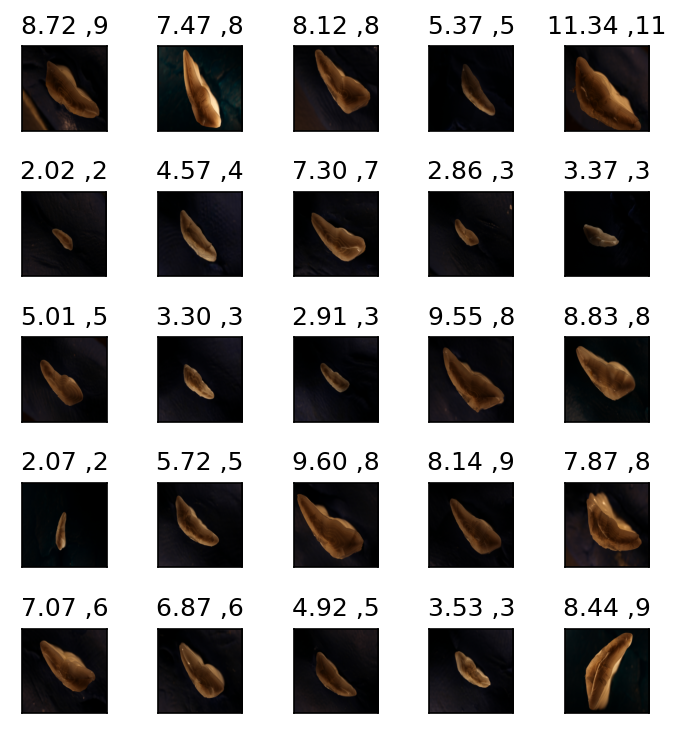

max:12.078588485717773
mean:5.409902389535626
min:0.9477762579917908
test mse:0.3737735574605572
test acc:0.6368932038834951
PREDS TYPE:<class 'list'>


 72%|███████▏  | 375/522 [02:40<01:02,  2.34it/s, Epoch=1, LR=1e-5, Train_Loss=1.13]

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)

print(CONFIG.device)
print(CONFIG.epochs)
#test_img = np.stack(df_test['image'].values  , axis=0)
#test_img = test_img * 1.0/255.0
print(type(test_imgs))
print(test_imgs.shape)
print(type(test_age))
print("#########")
print(type(train_imgs))
print(train_imgs.shape)

test_img = torch.from_numpy(test_imgs)
print("test_img shape:"+str( test_imgs.shape) )
print("test_img[0].shape:"+str( test_imgs[0].shape))
#test_img.to(CONFIG.device)

a_seed = CONFIG.KERAS_TRAIN_TEST_SEED #2021
numberOfFolds = CONFIG.n_fold #5
kfold = StratifiedKFold(n_splits=numberOfFolds, random_state=a_seed, shuffle=True)
#for i in range(0,5):
#CONFIG.epochs=5
test_15 = pd.DataFrame()
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, train_age.tolist())):
    #train_loader, valid_loader = prepare_data(fold=i)
    ######## K-FOLD Start #################
    train_imgs_new = train_imgs[train_idx]
    train_age_new = train_age[train_idx]
    val_imgs_new = train_imgs[val_idx]
    val_age_new = train_age[val_idx]
    
    train_dataset = codDataset(train_imgs_new, train_age_new)
    valid_dataset = codDataset(val_imgs_new, val_age_new)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)
    ######################### K-FOLD End #########################
    model, history, best_model_wts = run(model, optimizer, scheduler, train_loader, valid_loader, fold)

    fig = plt.figure(figsize=(5, 5))
    with torch.no_grad():
        PREDS_TEST  = []
        
        ceil_step = int(test_imgs.shape[0] / 25) + int(test_imgs.shape[0] % 25 > 0)
        for i in range(0, ceil_step):
            start_step = i * 25
            preds = model( torch.Tensor(test_imgs[start_step:start_step+25]).to(CONFIG.device) )
            preds = preds.cpu().detach().numpy()
            preds = preds.flatten()
            PREDS_TEST.extend(preds.tolist())
            
            if i == 0:
                fig = plt.figure(figsize=(5, 5))
                plt.subplots_adjust(hspace = 2.0)
                #test_imgs.shape[0]
                for j in range(0, 25):
                    fig.add_subplot(5, 5, j+1)
                    plt.imshow( test_imgs[j].transpose(1,2,0) )
                    plt.title(f'{preds[j]:.2f} ,{test_age[j]}')
                    plt.xticks([])
                    plt.yticks([])
                plt.tight_layout()
                plt.show()

        print("max:"+str(np.max( PREDS_TEST )))
        print("mean:"+str(np.mean( PREDS_TEST )))
        print("min:"+str(np.min( PREDS_TEST )))

        ROUNDED_PREDS_TEST = np.asarray(PREDS_TEST).round().astype('int')
        #print(ROUNDED_PREDS_TEST ) 
        #print(type(ROUNDED_PREDS_TEST))
        #print(ROUNDED_PREDS_TEST.shape)

        print("test mse:"+str( mean_squared_error(PREDS_TEST, test_age) )) 
        print("test acc:"+str( accuracy_score(ROUNDED_PREDS_TEST.tolist(), test_age.tolist() ) )) 
        print("PREDS TYPE:"+str(type(PREDS_TEST)))
        #print(PREDS_TEST.shape) ##list
        #print("PREDS:"+str(ROUNDED_PREDS_TEST))
        #print("TRUE:"+str(test_age))

        del model
        model = codModel(CONFIG.model_name)
        model.to(CONFIG.device);
        
        optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
        scheduler = fetch_scheduler(optimizer)
        test_15[str(fold)] = PREDS_TEST
        
test_15.to_csv(CONFIG.ROOTDIR+'preds.csv', index=False)

In [22]:
del model
torch.cuda.empty_cache()